In [1]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Optimizando la generación de electricidad

<img width=500 src="https://chintglobal.com/blog/wp-content/uploads/power-transmission-distribution-secrets-featured-banner.jpg"></img>

Las empresas de gestión de la energía necesitan anticiparse a la demanda de electricidad que va a haber en un determinado período. Una vez estimada esa demanda, y teniendo en cuenta qué centrales poseen, cuál es la capacidad de generación de cada una, y qué costes de operación tienen, necesitan decidir **cuánta electricidad producen con cada una de sus centrales en cada momento para garantizar que la demanda es satisfecha, a la vez que incurren en el menor coste posible**.

En esta práctica vamos a simular que somos un operador de una de estas empresas, y tenemos que decidir **qué hacer para gestionar la demanda de electricidad de un lugar ficticio**.

## Datos



### Estimación de demanda

Partimos de un mes de demanda total estimada (Julio de 2023), y consideramos que vamos a optimizar justo antes de que se inicie el mes. Si leemos las demandas predichas obtenemos lo siguiente:

In [2]:
import pandas as pd
hourly_demand = pd.read_csv('./demands.csv', parse_dates=['hora'], index_col='hora').sort_index()
hourly_demand

,demanda
hora,
2023-07-01 01:00:00,22424.578280
2023-07-01 02:00:00,20288.860640
2023-07-01 03:00:00,17962.060638
2023-07-01 04:00:00,16585.284168
2023-07-01 05:00:00,15976.342990
...,...
2023-07-31 20:00:00,27991.637100
2023-07-31 21:00:00,27942.225340
2023-07-31 22:00:00,27630.460640


Donde vemos que tenemos una estimación por hora (31 días · 24 horas = 744 filas), medida en MW. Hay que entender que **la marca de hora es la del final del periodo**, es decir, que entre las 00 horas y la 01 de la noche del 1 de julio se requieren 22414 MW, mientras que entre las 23 horas del 31 de julio y la medianoche del 1 de agosto necesitamos proveer 26400 MW.

Si pintamos todo el mes, podemos comprobar que la demanda sigue un patrón de picos y valles, de forma que hay un pico por cada día (si bien la magnitud de cada pico y valle depende de factores como si es un día laborable o no, la temperatura que hace, etc.):

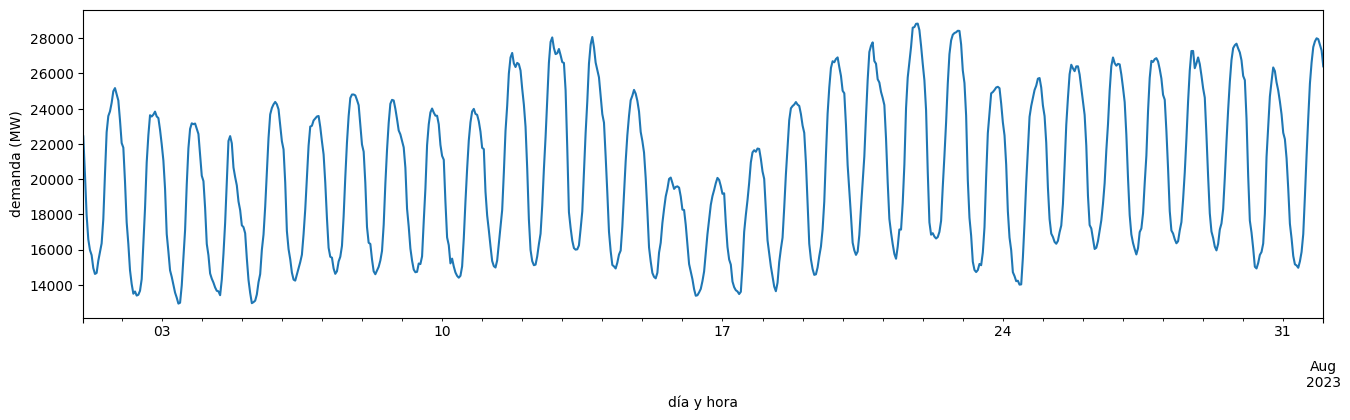

In [3]:
hourly_demand.plot(figsize=(16, 4), legend=False, ylabel='demanda (MW)', xlabel='día y hora');

Dentro de un día, también es bien conocido que hay horas valle y horas pico. En concreto, **si trabajamos con el primer día de todos (1 de julio)**:

In [4]:
daily_demand = hourly_demand.iloc[:24]   # los 24 primeros registros
daily_demand.T   # trasponer para que no ocupe tanto en pantalla

hora,2023-07-01 01:00:00,2023-07-01 02:00:00,2023-07-01 03:00:00,2023-07-01 04:00:00,2023-07-01 05:00:00,2023-07-01 06:00:00,2023-07-01 07:00:00,2023-07-01 08:00:00,2023-07-01 09:00:00,2023-07-01 10:00:00,...,2023-07-01 15:00:00,2023-07-01 16:00:00,2023-07-01 17:00:00,2023-07-01 18:00:00,2023-07-01 19:00:00,2023-07-01 20:00:00,2023-07-01 21:00:00,2023-07-01 22:00:00,2023-07-01 23:00:00,2023-07-02 00:00:00
demanda,22424.57828,20288.86064,17962.060638,16585.284168,15976.34299,15686.931226,14952.81358,14618.695932,14675.16652,15365.754756,...,22663.40182,23579.55476,23844.51946,24329.69594,24988.99004,25165.75476,24815.16652,24461.6371,23335.93122,22047.99004


Vemos claramente que **durante la madrugada la demanda baja, para después ir subiendo a lo largo de la mañana, alcanzar la demanda máxima a media tarde, y luego volver a ir decayendo según avanza la noche**:

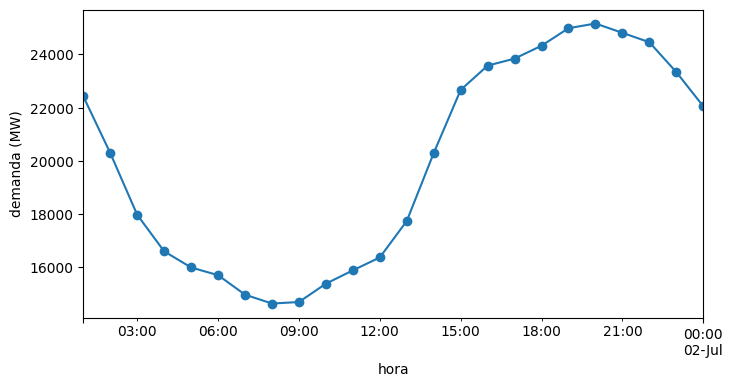

In [5]:
daily_demand.plot(marker='o', legend=False, figsize=(8, 4), ylabel='demanda (MW)');

### Centrales

Lo normal es que una compañía disponga de varios tipos de centrales, cada una de ellas con unas características propias. Habitualmente la primera distinción que se hace es por el tipo de energía de cada una.

En este caso vamos a suponer que operamos **10 centrales diferentes, pertenecientes a 6 tipos de energía (carbón, nuclear, petróleo, gas, hidráulica y biomasa) y denominadas con las letras de la A la J**.

A continuación figuran la fuente de energía de cada una, el combustible que consumen (que no es exactamente lo mismo que la fuente de su energía, pero que es el factor que determina los costes, como veramos más adelante), así como sus capacidades máximas de producción:

In [6]:
plants = pd.read_csv('plants.csv', index_col='central').sort_index()
plants

,tipo,combustible,producción
central,,,
A,carbón,carbón sub-bituminoso,5720.22000
B,carbón,carbón bituminoso,5244.74856
C,carbón,carbón bituminoso,861.36600
D,nuclear,nuclear,3252.82456
E,nuclear,nuclear,4177.39200
F,petróleo,licor negro,151.67496
G,biomasa,licor negro,941.91944
H,gas,gas natural,3522.61048
I,hidráulica,agua,536.11236


### Costes

Dentro de los costes, a cada central le son aplicables los siguientes:
* El del combustible que usa (es decir, **lo que cuesta producir con ella 1 MWh**).
* El de operación (**lo que cuesta mantenerla operativa durante una hora, independientemente de lo que esté produciendo**).
* De encendido y apagado (**lo que cuesta encenderla o apagarla**, que asumimos que es idéntico en ambos casos).
* Sanitario (una estimación del coste en salud que supone usar una central; esto es **solamente aplicable a las centrales de carbón A, B y C, y es proporcional a la cantidad de carbón quemado**).

**Los tres primeros costes se pueden considerar constantes a lo largo del mes** y están recogidos en la siguiente tabla:

In [7]:
plant_costs = pd.read_csv('./plant_costs.csv', index_col='combustible').sort_index()
plant_costs

,coste_comb,coste_oper,coste_on_off
combustible,,,
agua,0.000,8.176099,0.0
carbón bituminoso,18.050,7.384495,147.0
carbón sub-bituminoso,9.195,7.380880,147.0
gas natural,17.435,5.287164,72.0
licor negro,7.440,5.295063,72.0
nuclear,3.615,16.310160,0.0


En cambio, **los costes sanitarios están calculados por cada hora individualmente**. Puedes consultarlos en esta otra tabla:

In [8]:
health_costs = pd.read_csv('./health_costs.csv', parse_dates=['hora'], index_col=['hora', 'central']).sort_index()
health_costs

coste_salud
hora                central             
2023-07-01 01:00:00 A           2.148816
                    B           9.030773
                    C           3.422946
2023-07-01 02:00:00 A           2.022208
                    B           7.706546
...                                  ...
2023-07-31 23:00:00 B          13.274831
                    C          14.214563
2023-08-01 00:00:00 A           2.562029
                    B          12.606380
                    C          10.906997

[2232 rows x 1 columns]

Si pintamos estos costes a lo largo de todo el mes, vemos que **por lo general las centrales B y C tienen mayor coste que la A**, pero no forman un patrón tan claro como el de la demanda:

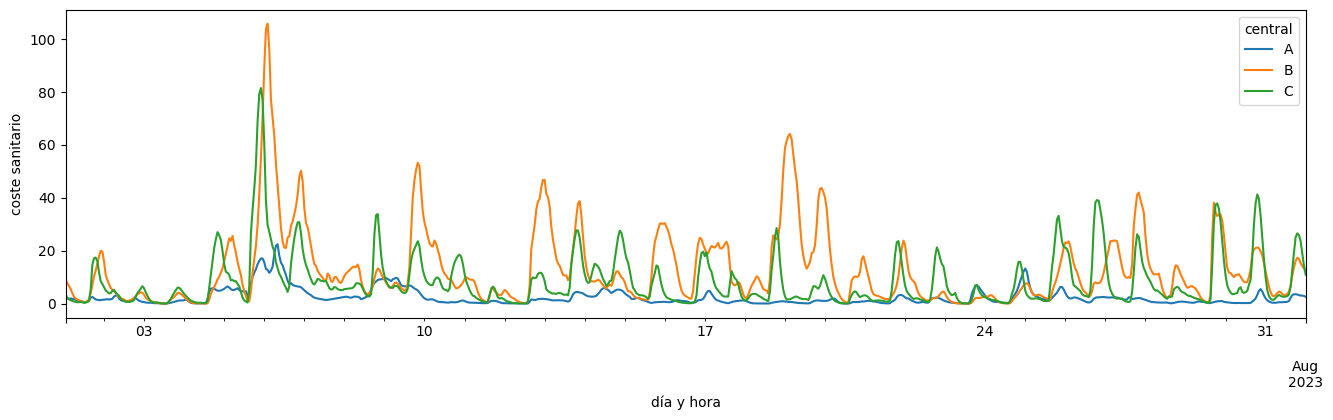

In [9]:
health_costs.reset_index().pivot(index='hora', columns='central', values='coste_salud').plot(figsize=(16, 4), ylabel='coste sanitario', xlabel='día y hora');

Restringiéndolo al día de interés (1 de julio), los costes son bastante bajos (menos de 20 por hora), pero claramente superiores en las horas nocturnas que en las diurnas:

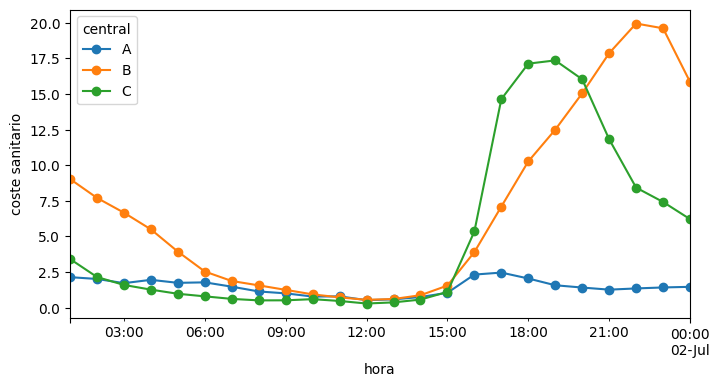

In [10]:
daily_health_costs = health_costs.iloc[:72]   # 3 centrales, cada una de ellas 24 horas -> 72 filas
daily_health_costs.reset_index().pivot(index='hora', columns='central', values='coste_salud').plot(marker='o', figsize=(8, 4), ylabel='coste sanitario');

## Restricciones y suposiciones

Existen una serie de limitaciones establecidas por razones de seguridad y eficiencia:
* <u>Las centrales nucleares deben estar siempre operativas</u> (sólo se pueden apagar por lo que se conoce como "paradas programadas", cosa que ignoramos aquí).
* <u>Si una central está operativa (en marcha), tiene que producir al menos un cierto porcentaje de su capacidad total</u>. Este mínimo es de:
  * **Un 80% para las centrales nucleares**.
  * Un **1% para el resto**.
* Además, para evitar cambios bruscos, se establece también <u>un porcentaje máximo de cambio entre la producción de una hora y de la siguiente (ya sea por aumento o por disminución de producción de energía)</u>. En concreto, este límite es de:
  * **Un 20% para las centrales nucleares**.
  * **Un 25% para las de carbón**.
  * **El 100% para el resto** (es decir, que pueden pasar de estar apagadas a producir al 100% de su capacidad, o viceversa, pasar de producir al 100% a estar apagadas en la hora siguiente).

Asímismo, podemos por simplicidad asumir una serie de hechos:
* **El encendido y apagado de una central es instantáneo** una vez que se ejecuta.
* Lo mismo sucede para las subidas y bajadas de niveles de producción: basta con decidir para cada hora cuánto se produce, y **si eso implica subir o bajar el nivel, la subida o bajada se produce al momento**.
* Justo en el cambio de una determinada hora (es decir, el el minuto 0 y segundo 0) es cuando se ejecutan las instrucciones correspondientes: encender/apagar, producir a un determinado nivel, etc. **Como esas acciones se consideran instantáneas, entre el inicio de la hora $h$ y el inicio de la hora $h+1$ la situación de la central asociada no cambia**.
* **Las centrales de la D a la J se considera que no tienen coste sanitario, sean cuales sean el día y la hora**.


## Optimización

A continuación vamos a ir generando el modelo de optimización correspondiente, primero con algunas simplificaciones adicionales y luego ya reproduciendo todo el funcionamiento descrito arriba.


### Apartado A (4 puntos)

Suponiendo que **todas las centrales están en marcha a las 00 horas del 1 de julio** (es decir, que no hay que encenderlas en caso de que haga falta que produzcan), y que **ese día tampoco se puede apagar ninguna**, se pide:

1. Formular el problema matemáticamente de cómo se debe operar a lo largo del día.
2. Trasladar esa formulación a la librería `PuLP`.
3. Resolver el problema y analizar la solución obtenida, pintando:
   * Cuánto produce cada central en cada hora.
    * ¿Hay alguna que produzca lo mínimo posible? Si es así, ¿durante qué horas del día?
    * ¿Hay alguna que produzca lo máximo posible? Si es así, ¿durante qué horas del día?
    * ¿Hay alguna que cambie entre una hora y la siguiente lo máximo posible? Si es así, ¿creciendo o decreciendo de producción?
   * Cuál es la producción total por hora.
    * ¿Cómo compara con respecto a la demanda?
   * Cuál es el coste incurrido por cada central en cada hora, desglosado en sus componentes (combustible, operación y sanitario).
    * ¿Cuál es el componente mayoritario de coste?
    * ¿Y el menos importante?
   * Cuál es el coste total por hora.
    * ¿Qué horas son las más y las menos costosas?
   * Cuál es el coste por central en el día.
    * ¿Qué centrales son las más y las menos costosas?
   * Cuál es el coste total del día.
4. ¿Cuánto tiene que caer la demanda en % para que el problema esté en el límite de ser o no factible? Aquí puedes suponer que **la demanda decae en el mismo porcentaje para las 24 horas del día**. Muestra que para ese valor límite:
  * En algún momento del día la producción cae a su mínimo posible. ¿Qué momento es ese y por qué?
  * El coste es más bajo que en el escenario anterior. ¿Cuál sería este coste mínimo?
  * Si decae todavía un poco más, el problema se convierte en no factible.

#### 1. Formulación matemática

##### 1.1 Esquema visual:

<img src='.\img\Esquema visual.png'>

##### **Definición de variables:**

* $c \text{: central de producción de energía} \in \text{conjunto de centrales } C$
* $h \text{: hora} \in \text{conjunto de horas que componen un día } H$
* $e_{c,h}$​: Energía porducida por la central $c$, durante la hora $h$ 
* $x_{c,h}$: Variable binaria que indica si la central $c$ está encendida (1) o no (0) en la hora $h$.
* $\gamma_{c,h}$: Variable binaria que indica la existencia de un cambio de estado la central $c$ en la hora $h$ respecto a $h-1$, siendo (1) que hubo cambio de estado y (0) que no hubo.
* $P_c$: Costo de combustible de la central $c$.
* $O_{c}$: Costo de operativo de la central $c$ por hora.
* $S_{c,h}$: Costo sanitario por hora de la central $c$ en la hora $h$.
* $D_h$ Demanda total de energía en la hora $h$.
* $ON_c$: Costo de encender/apagar de la central $c$
* $\alpha_c$: Porcentaje de producción de la central $c$
* $\beta_c$: Porcentaje de cambio mínimo de producción de energía por central

Donde:

Las **Variables de decisión**: 

   * $e_{c,h}$​
   * $x_{c,h}$

Tienen la función objetivo de minimizar el costo total de producción de energía. Este costo se compone de:

1.  Costo de combustible:

    $\sum_{c\in C} \sum_{h \in H} P_c \cdot e_{c,h}$  
        
2. Costo operacional: 

    $\sum_{c \in C} \sum_{h \in H} x_{c,h} \cdot O_{c}$

3. Costo sanitario: 

    $\sum_{c \in C} \sum_{h \in H} S_{c,h} \cdot e_{c,h}$     

4. Costo de encender o apagar una central:

    $\sum_{c \in C} \sum_{h \in H} ON_c \cdot  x_{c,h}$.



La **Función objetivo** puede ser expresada como: 

$$
\min \left( \sum_{c \in C} \sum_{h \in H} P_c \; e_{ch} + \sum_{c \in C} \sum_{h \in H} O_c \; x_{ch} + \sum_{c \in C} \sum_{h \in H} S_{ch} \; e_{ch} + \sum_{c \in C} \sum_{h \in H} ON_c \cdot  \gamma_{c,h} \right) 
$$
$
\text{s.t.}
$
$$

\sum_{c \in C} e _{c,h} \geq D_h  \; \forall\;    h \in H  \hspace{40pt} \text{(Satisfacción de la demanda)}

$$

$$
 e_{c,h} \leq  x_{c,h} \cdot E_c \; \forall \;  h \in H, c \in H   \hspace{20pt} \text{(Producción de energía máxima)}

$$


$$
e_{c,h} \geq x_{c,h} \cdot E_c \cdot \alpha \; \forall \; h \in  H,  \hspace{30pt} \text{(Producción de energía mínima)}  \\
\text{Donde: }\\

\alpha = 0.8 \; \forall \; c \in \text{Conjunto de centrales nucleares}\\
\alpha = 0.01 \; \forall \; c \notin \text{Conjunto de centrales nucleares}\\

$$

$$

\hspace{40pt} \| e_{c,h} - e_{c,h-1} \| \leq \beta \cdot E_c \; \forall \; h \in H, \hspace{20pt} \text{(Cambio máximo de producción de energía)}\\
\text{Donde: } \\
        \beta = 0.2 \; \forall \; c \in \text{Conjunto de centrales nucleares} \\
        \beta = 0.25 \; \forall \; c \in \text{Conjunto de centrales a carbón} \\
        \beta = 1 \; \forall \; c \notin \text{Conjunto de centrales nucleares o carbón}

$$


$$

x_{c,h} = 1 \; \forall \;   h \in H , c \in C\;\hspace{10pt} \text{(Estado de plantas)}\\
  
$$

$$

\gamma_{c,h} = \| x_{c,h-1} - x_{c,h} \| \hspace{15pt} \text{(Cambio de estado de encendido/apagado)}\\
$$

Ahora bien, la función objetivo se define de manera general para todo el ejercicio. Sin embargo, debido a que se supone que **todas las centrales están en marcha a las 00 horas del 1 de julio** (es decir, que no hay que encenderlas en caso de que haga falta que produzcan), y que **ese día tampoco se puede apagar ninguna**, la variable $x_{c,h}$ siempre es 1. 

#### 2. Formulación en la librería `PulP`

In [11]:
# Definición del problema
prob = LpProblem("Optimizacion_Energia", LpMinimize)

##### Definición de variables

In [12]:
C = list(plants.reset_index()['central']) # Conjunto de centrales C
H = list(daily_demand.index) # Conjunto de horas que componen un día H

In [13]:
def crear_variables_decision(C, H):
    # Variables de decisión
    e_ch = LpVariable.dicts('MWh', (C, H), lowBound=0, cat=LpContinuous) # Energía producida por la central c durante la hora h
    x_ch = LpVariable.dicts('X', (C, H), cat='Binary') # Variable binaria que indica si la central c esta encendida o no en la hora h
    gamma_ch = LpVariable.dicts('gamma', (C, H), cat='Binary') # Variable binaria que indica si la central c está encendida (1) o no (0) en la hora h.
    return e_ch, x_ch, gamma_ch

e_ch, x_ch, gamma_ch = crear_variables_decision(C, H)


In [14]:
alpha_values = [0.8 if c in ['D', 'E'] else 0.01 for c in C]
df_alpha = pd.DataFrame({
    'central': C,
    'alpha': alpha_values
}).set_index('central')

alpha = df_alpha.squeeze() #Porcentaje de producción de la central c


beta_values = [0.2 if c in ['D', 'E'] else 0.25 if c in ['A','B', 'C', 'J'] else 1 for c in C]
df_beta = pd.DataFrame({
    'central': C,
    'beta': beta_values
    }).set_index('central')

beta = df_beta.squeeze() #Porcentaje de cambio mínimo de producción de energía por central


In [15]:
#Producción máxima
E_c = plants.reset_index()[['central','producción']].set_index('central') #Energía máxima de energía para una central c

In [16]:
## Costo del combustible
P_c = plants.join(plant_costs, on= 'combustible').reset_index()[['central','coste_comb']].set_index('central') # Unimos las tablas y seleccionamos las columnas necesarias
P_c.index.name = None # Unimos las tablas y seleccionamos las columnas necesarias
for h in H:
    P_c[h] = P_c['coste_comb']
P_c = P_c.drop(['coste_comb'], axis=1) # Costo de combustible de la central $c$.

In [17]:
## Costos operativos
O_c = plants.join(plant_costs, on= 'combustible').reset_index()[['central','coste_oper']].set_index('central')
O_c.index.name = None # Unimos las tablas y seleccionamos las columnas necesarias
for h in H:
    O_c[h] = O_c['coste_oper']
O_c = O_c.drop(['coste_oper'], axis=1) # Costo de operativo de la central $c$ por hora.

In [18]:
## Costos sanitarios 
S_ch = health_costs.reset_index().sort_index() # Costo sanitario por hora de la central $c$ en la hora $h$.
S_ch = S_ch.pivot(index='hora', columns='central', values ='coste_salud') # Pivotamos el DataFrame 'S_ch' para reorganizarlo y facilitar su análisis.

non_carbon_plants = ['D', 'E', 'F', 'G', 'H', 'I', 'J']

# El método reindex se utiliza para agregar las plantas sin costos de salud al DataFrame.
# El parámetro 'fill_value' se establece en 0, lo que reemplaza todos los valores faltantes con 0.
S_ch= S_ch.reindex(columns=S_ch.columns.tolist() + non_carbon_plants, fill_value=0)

In [19]:
D_h = daily_demand # Demanda total de energía en la hora $h$.

In [20]:
ON_c = plants.join(plant_costs, on= 'combustible').reset_index()[['central','coste_on_off']].set_index('central')
ON_c.index.name = None # Unimos las tablas y seleccionamos las columnas necesarias
for n in H:
    ON_c[n] = ON_c['coste_on_off']
ON_c = ON_c.drop(['coste_on_off'], axis=1) # Costo de encender/apagar de la central $c$

##### Definición de la función objetivo

In [21]:
def crear_funcion_obj(prob, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, C, H):
    # Función: Costo de combustible
    comb = (lpSum([P_c[h][c] * e_ch[c][h] for c in C for h in H]))

#Función : Costo operacional
    op =  (lpSum([O_c[h][c] * x_ch[c][h] for c in C for h in H]))

# Función: Costo sanitario
    san = lpSum([S_ch[c][h] * e_ch[c][h] for c in C for h in H])

# Función costo de encender o apagar una central (Se define para su uso a posteriori, puesto que para este ejercicio nunca se aplicará)

    on_off = (lpSum([ON_c[h][c] * gamma_ch[c][h] for c in C for h in H]))

# Definiendo la función objetivo como:
    
    prob+= comb + op + san + on_off
    
    return prob 

In [22]:
prob= crear_funcion_obj(prob, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, C, H)

##### Definición de las restricciones

In [23]:
def anadir_restriccion_demanda(prob, e_ch, D_h, C, H):
    ## Satisfacción de la demanda
    for h in H:
        prob += (lpSum(e_ch[c][h] for c in C) >= D_h.loc[h][0]) # Satisfacción de la demanda

    return prob

In [24]:
prob= anadir_restriccion_demanda(prob, e_ch, D_h, C, H)

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\152074783.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += (lpSum(e_ch[c][h] for c in C) >= D_h.loc[h][0]) # Satisfacción de la demanda


In [25]:
def anadir_restriccion_xch(prob, x_ch, C, H):
    # Todas las centrales están encendidas en todas las horas
    for c in C:
        for h in H:
            prob += x_ch[c][h] == 1  
    
    return prob

In [26]:
prob= anadir_restriccion_xch(prob, x_ch, C, H)

In [27]:
def anadir_otras_restricciones(prob, H, C, e_ch, x_ch, E_c, beta, alpha, gamma_ch):
    ## Producción máxima
    for c in C:
        for h in H:
            prob += e_ch[c][h] <= x_ch[c][h] * E_c.loc[c][0]

    ## Producción mínima
    for c in C:
        for h in H:
            prob += e_ch[c][h] >= x_ch[c][h] * E_c.loc[c][0]*alpha[c]

    ## Cambio máximo de producción de energia
    for c in C:
        for h in range(1, len(H[0:-1])):
            prob += e_ch[c][H[h]] - e_ch[c][H[h-1]] <= beta[c] * E_c.loc[c][0]
            prob += e_ch[c][H[h-1]] - e_ch[c][H[h]] <= beta[c] * E_c.loc[c][0]    

    # Cambio de estado de cada central
    for c in C:
        for h in range(1, len(H[0:-1])):
            prob += gamma_ch[c][H[h]] == x_ch[c][H[h]] - x_ch[c][H[h-1]]  # Cambio de estado de encendido/apagado
            prob += gamma_ch[c][H[h]] == x_ch[c][H[h-1]] - x_ch[c][H[h]]  # Cambio de estado de encendido/apagado           

    return prob                 

In [28]:
prob= anadir_otras_restricciones(prob, H, C, e_ch, x_ch, E_c, beta, alpha, gamma_ch)

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] <= x_ch[c][h] * E_c.loc[c][0]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] >= x_ch[c][h] * E_c.loc[c][0]*alpha[c]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [29]:
status = prob.solve()
print('Status:', LpStatus[status])
value(prob.objective)
costo_inicial = value(prob.objective)

Status: Optimal


#### 3. Resolver el problema y analizar la solución obtenida, pintando:

In [30]:
# Almacenamiento de las salidas del modelo en diccionarios.
def almacenar_resultados_modelo(prob):
    result_energy = {}
    result_central = []
    result_variable = []
    result_hour = []

    for v in prob.variables():
        p = (v.name).split('_')[1]
        e = v.varValue
        h = (v.name).split('_')[2] + '-' + (v.name).split('_')[3] + '-' + (v.name).split('_')[4] + '-' + (v.name).split('_')[5]

        result_central.append(p)
        result_variable.append(e)
        result_hour.append(h)
        result_energy['central'] = result_central
        result_energy['hora'] = result_hour
        result_energy['energía'] = result_variable

    df_result_energy = pd.DataFrame(result_energy)

    indexes = df_result_energy.index[240:]
    df_result_energy = df_result_energy.drop(indexes)
    return df_result_energy
    
df_result_energy = almacenar_resultados_modelo(prob)
    

<hr>

##### **Cuánto produce cada central en cada hora.**


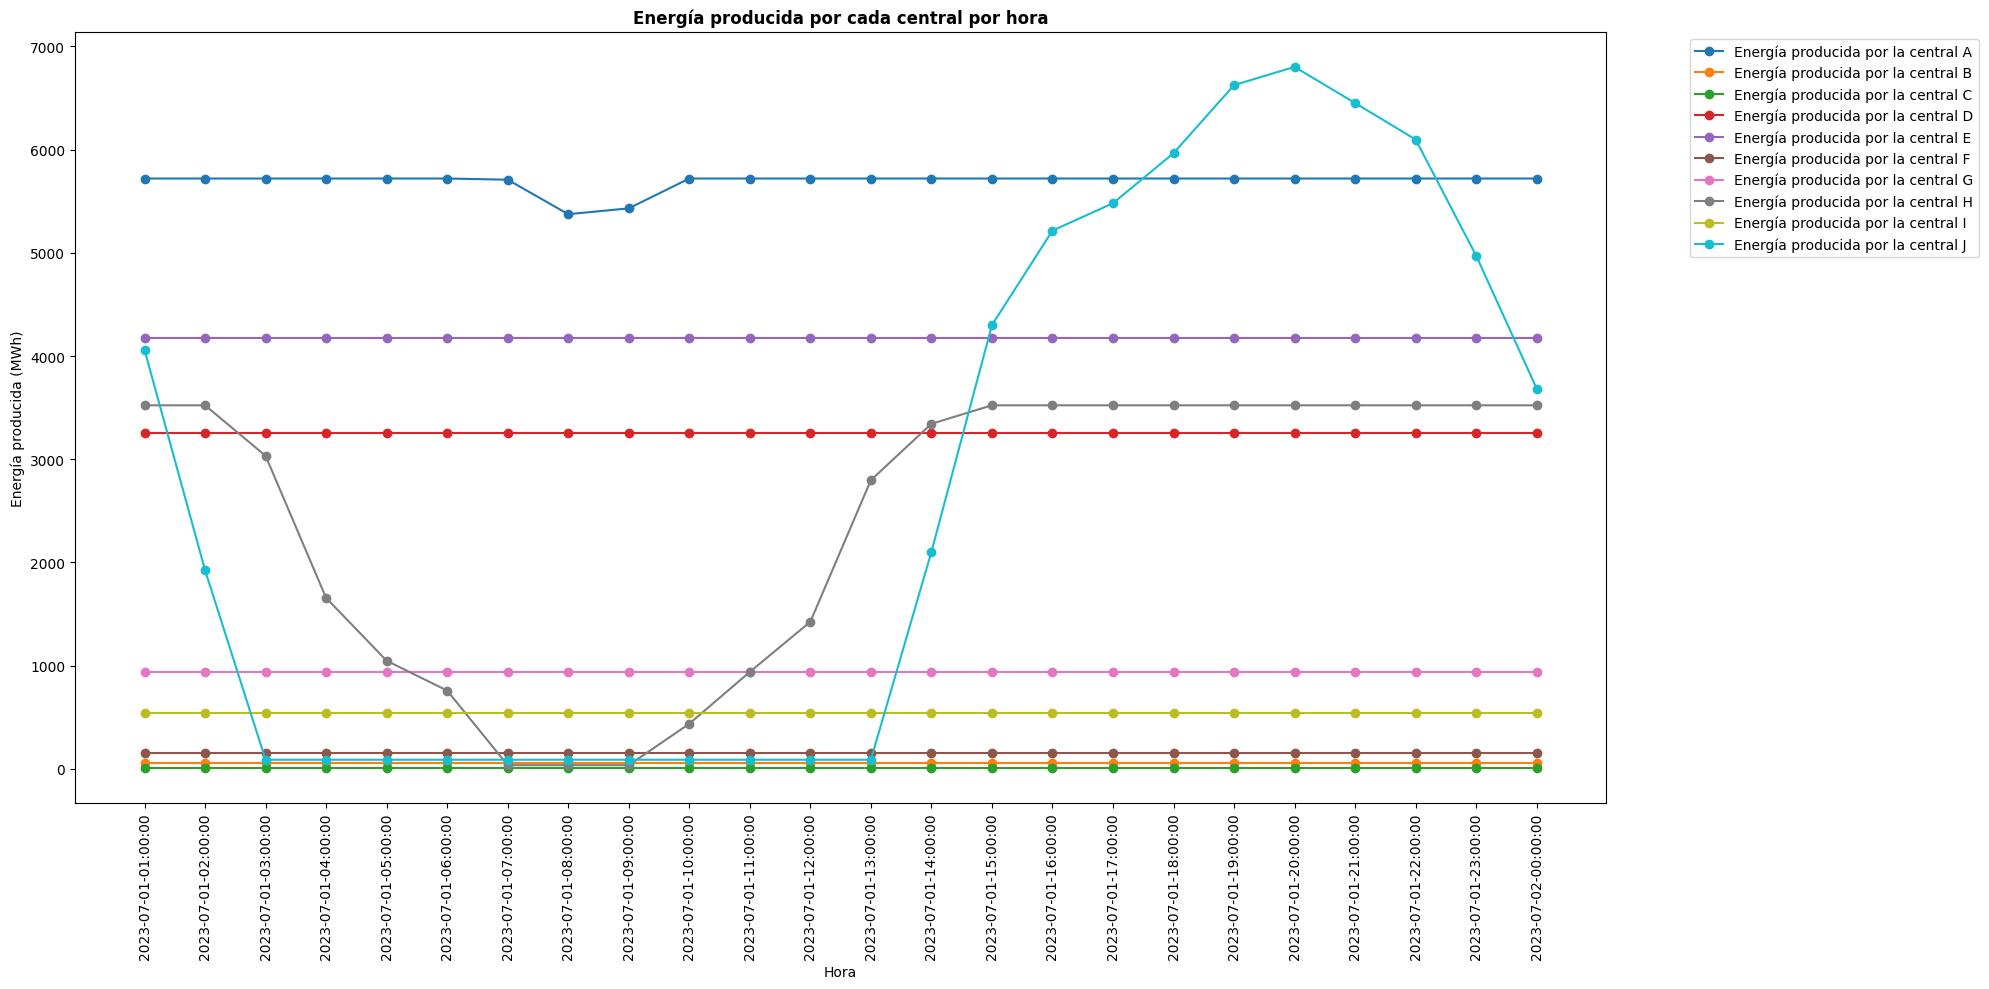

In [31]:
centrals = df_result_energy['central'].unique()

plt.figure(figsize=(20,10))

for central in centrals:
    plt.plot(df_result_energy[df_result_energy['central'] == central]['hora'], 
             df_result_energy[df_result_energy['central'] == central]['energía'], 
             marker='o', linestyle='-', 
             label=f'Energía producida por la central {central}')

    
plt.title(f'Energía producida por cada central por hora', weight= 'bold')
plt.xlabel('Hora')
plt.ylabel('Energía producida (MWh)')
plt.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##### ¿Hay alguna que produzca lo mínimo posible? Si es así, ¿durante qué horas del día?, ¿Hay alguna que produzca lo máximo posible? Si es así, ¿durante qué horas del día?

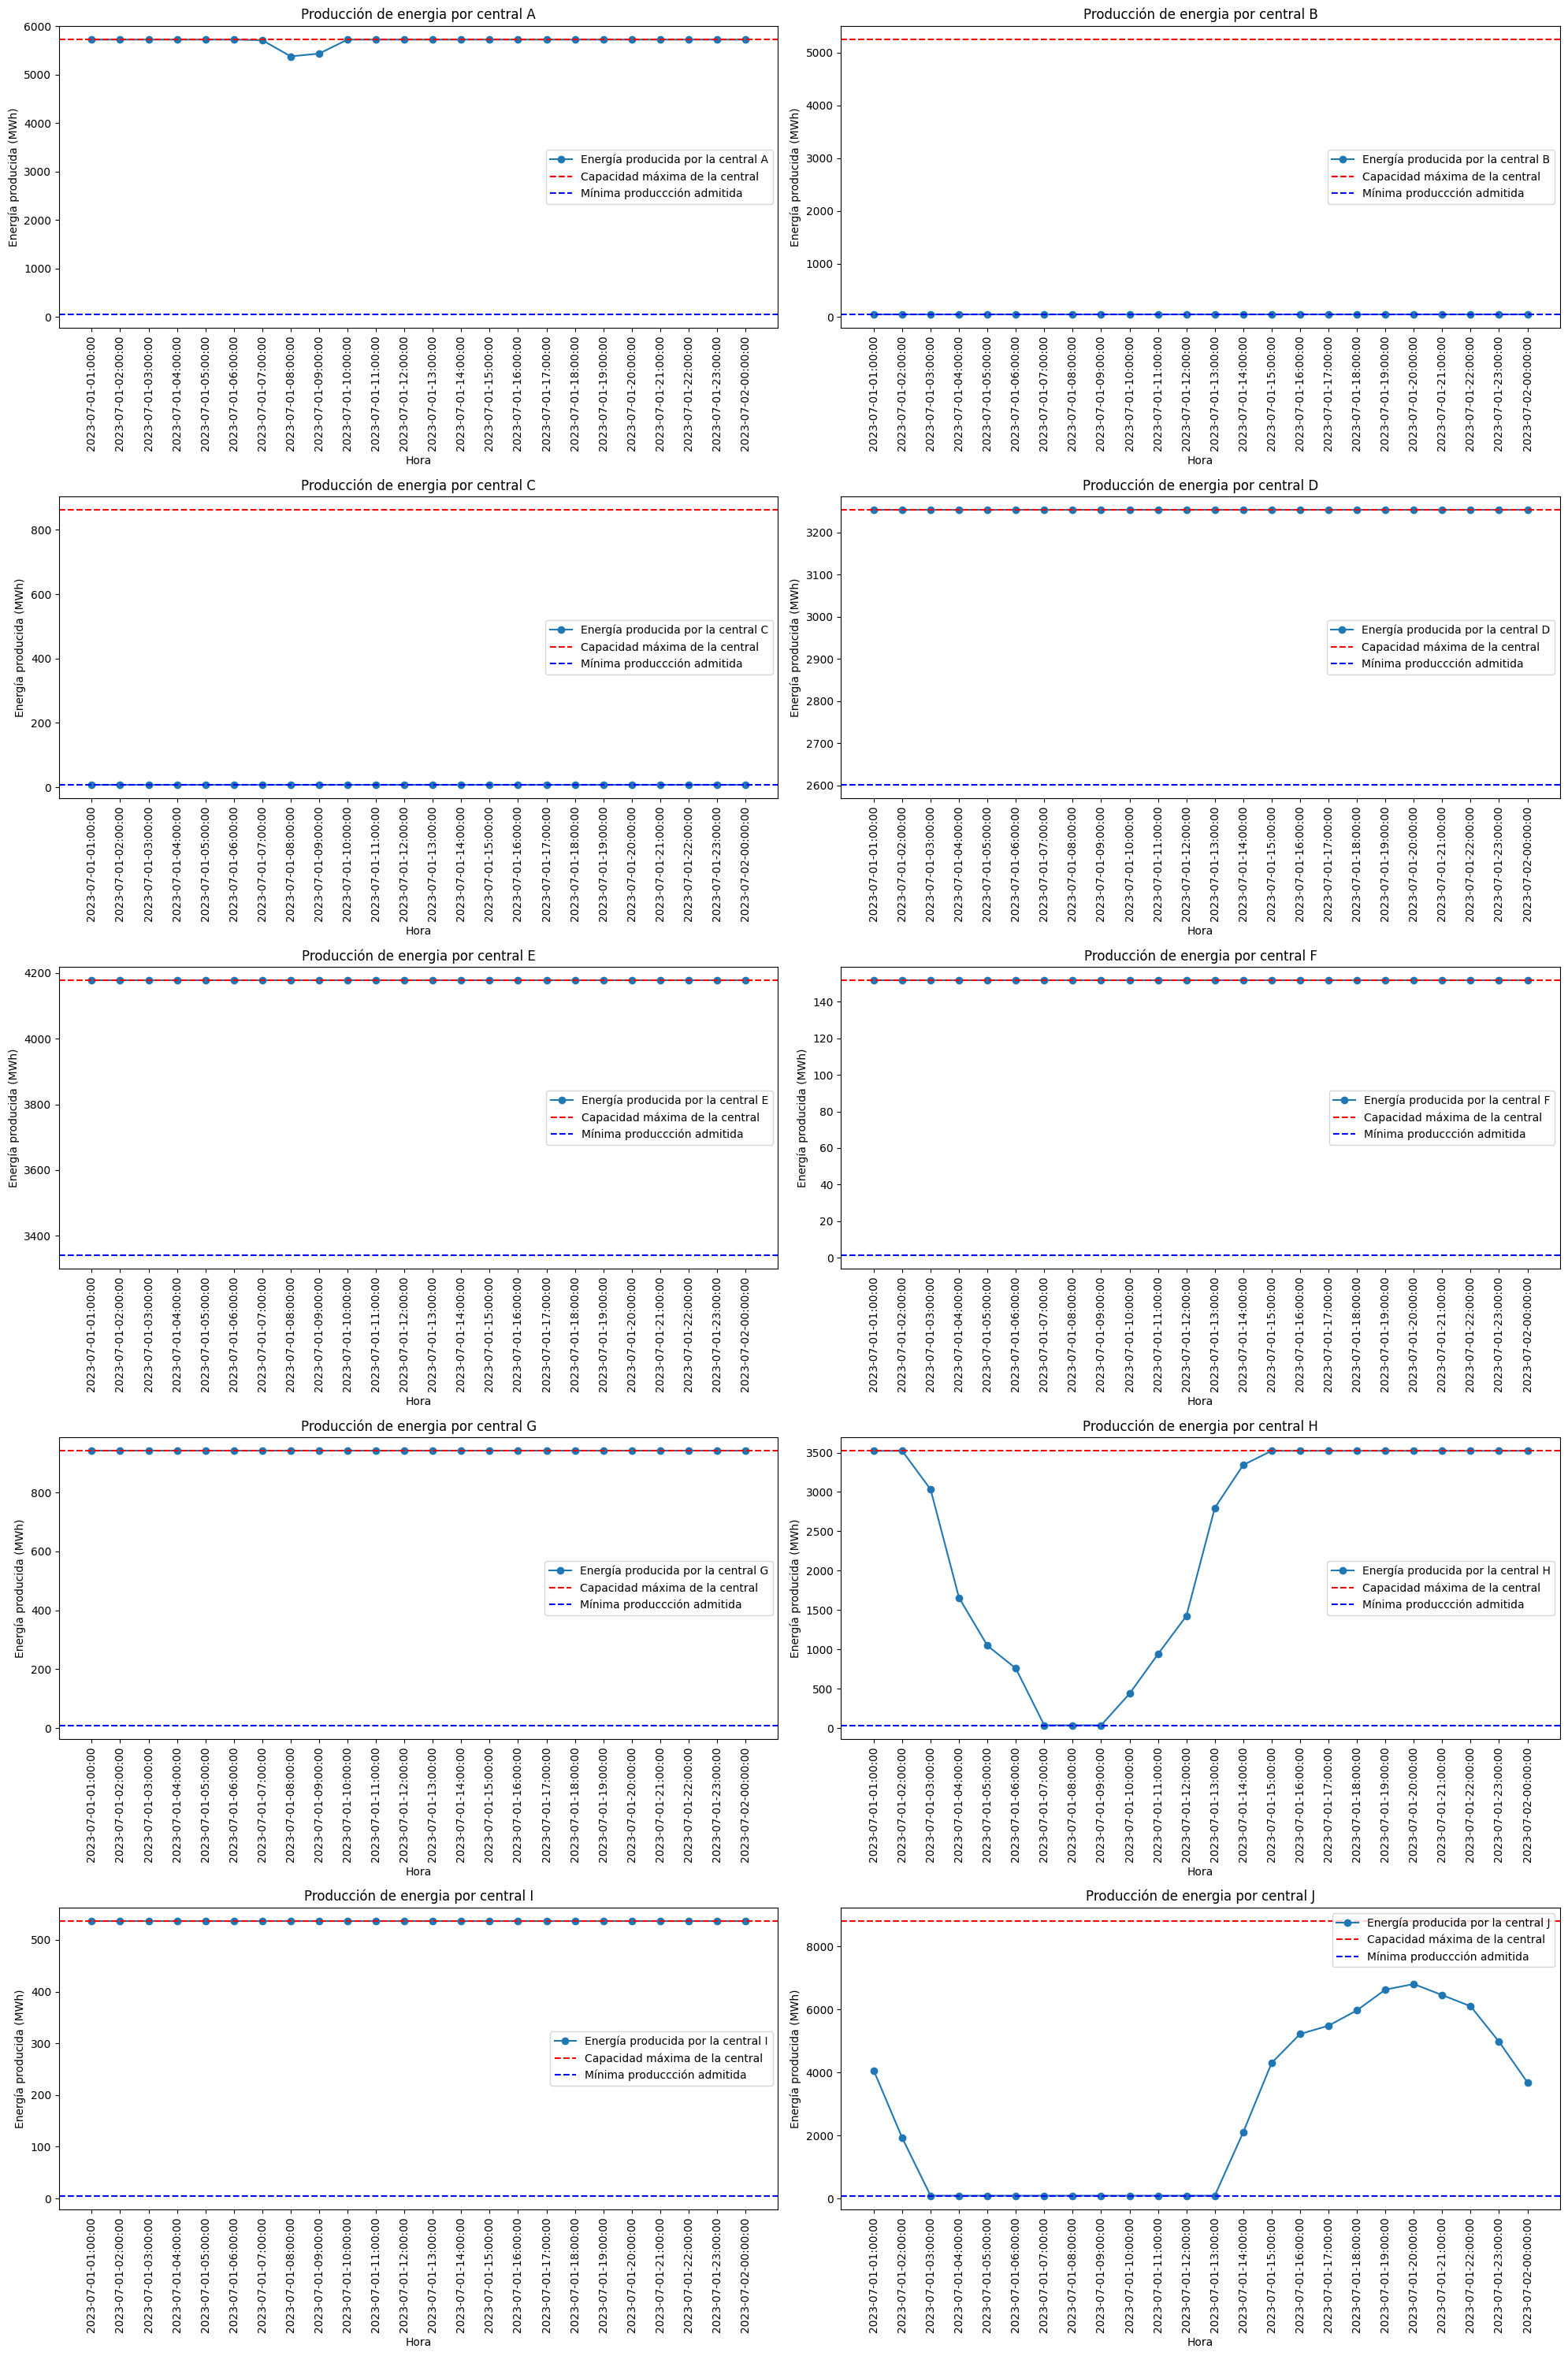

In [32]:
centrals = df_result_energy['central'].unique()
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,30))

for i, central in enumerate(centrals):
    row = i // 2
    col = i % 2
    limite_superior = E_c.loc[central, 'producción']  # Obtiene el límite superior para la central
    limite_inferior = E_c.loc[central, 'producción'] * df_alpha.loc[central, 'alpha']  # Obtiene el límite inferior para la central
    axs[row, col].plot(df_result_energy[df_result_energy['central'] == central]['hora'], 
                       df_result_energy[df_result_energy['central'] == central]['energía'], 
                       marker='o', linestyle='-', 
                       label=f'Energía producida por la central {central}')
    axs[row, col].axhline(y=limite_superior, color='r', linestyle='--', label='Capacidad máxima de la central')
    axs[row, col].axhline(y=limite_inferior, color='b', linestyle='--', label='Mínima produccción admitida')
    axs[row, col].set_title(f'Producción de energia por central {central}')
    axs[row, col].set_xlabel('Hora')
    axs[row, col].set_ylabel('Energía producida (MWh)')
    axs[row, col].tick_params(axis='x', rotation=90)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


##### ¿Hay alguna que cambie entre una hora y la siguiente lo máximo posible? Si es así, ¿creciendo o decreciendo de producción?

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\2419810586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_central['cambio_energia'] = df_central['energía'].diff()  # Calcula la derivada de la energía
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\2419810586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_central['cambio_energia'] = df_central['energía'].diff()  # Calcula la derivada de la energía
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\2419810586.py:7: SettingWithCopyWarning: 


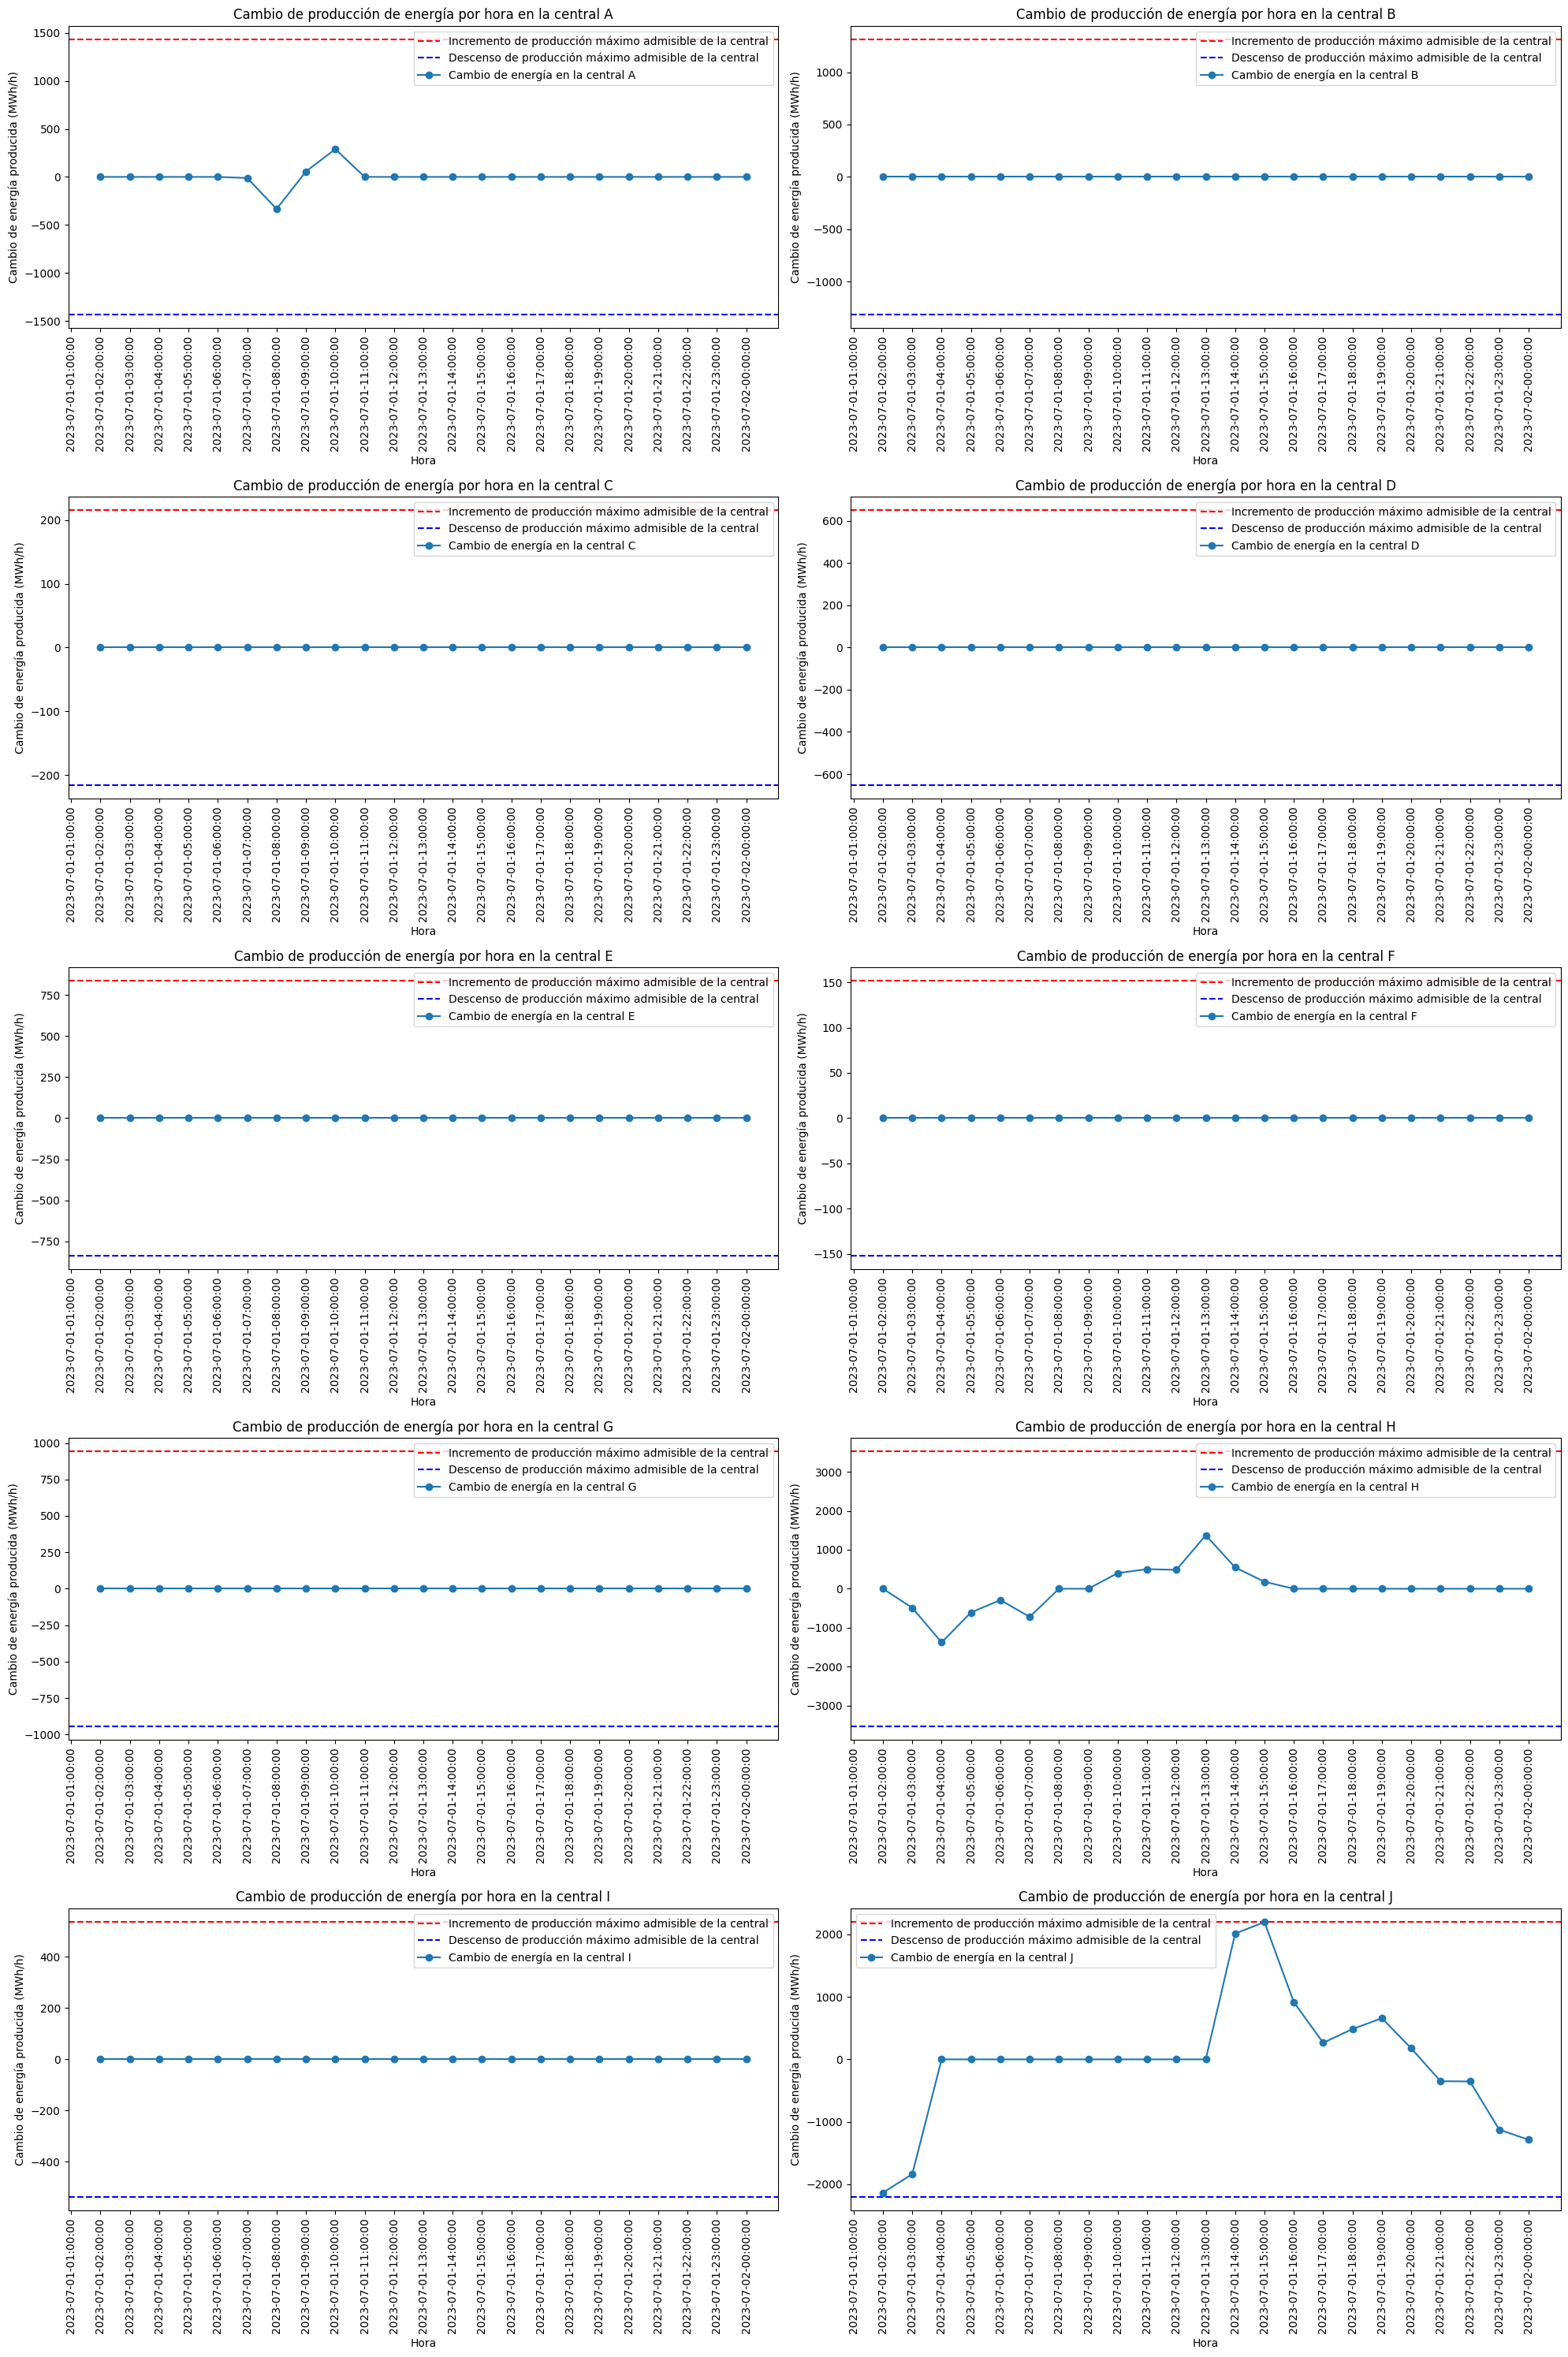

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,30))

for i, central in enumerate(centrals):
    row = i // 2
    col = i % 2
    df_central = df_result_energy[df_result_energy['central'] == central]
    df_central['cambio_energia'] = df_central['energía'].diff()  # Calcula la derivada de la energía
    
    limite_superior = E_c.loc[central, 'producción'] * df_beta.loc[central, 'beta']  # Obtiene el límite superior para la central
    limite_inferior = E_c.loc[central, 'producción'] * df_beta.loc[central, 'beta']  * -1 # Obtiene el límite inferior para la central
    
    axs[row, col].axhline(y=limite_superior, color='r', linestyle='--', label='Incremento de producción máximo admisible de la central')
    axs[row, col].axhline(y=limite_inferior, color='b', linestyle='--', label='Descenso de producción máximo admisible de la central')

    axs[row, col].plot(df_central['hora'], 
                       df_central['cambio_energia'], 
                       marker='o', linestyle='-', 
                       label=f'Cambio de energía en la central {central}')
    axs[row, col].set_title(f'Cambio de producción de energía por hora en la central {central}')
    axs[row, col].set_xlabel('Hora')
    axs[row, col].set_ylabel('Cambio de energía producida (MWh/h)')
    axs[row, col].tick_params(axis='x', rotation=90)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


Por medio de la derivada de la funcion de producción de energía es posible visualizar los incrementos y descensos realizados por cada planta en su produccicón; valores en cero indican que la producción fue constante entre una hora y la siguiente.
A su vez se establecen para cada uno de los gráficos los limites superiores e inferiores admisibles correspondientes a cada planta de acuerdo a su tipología de combustible: Los graficos demuestran que en ninguno de los casos son sobrepasados o igualados (pasar de 0 a alguno de los limites) los limites de incremento y descenso de producción de energía admisibles.

##### **Cuál es la producción total por hora**

In [34]:
df_result_energy['hora'] = pd.to_datetime(df_result_energy['hora'])
df_energia_demanda = pd.merge(df_result_energy, D_h, on='hora', how='left')
df_energia_demanda = df_energia_demanda.astype({'hora': 'string'})


<function matplotlib.pyplot.show(close=None, block=None)>

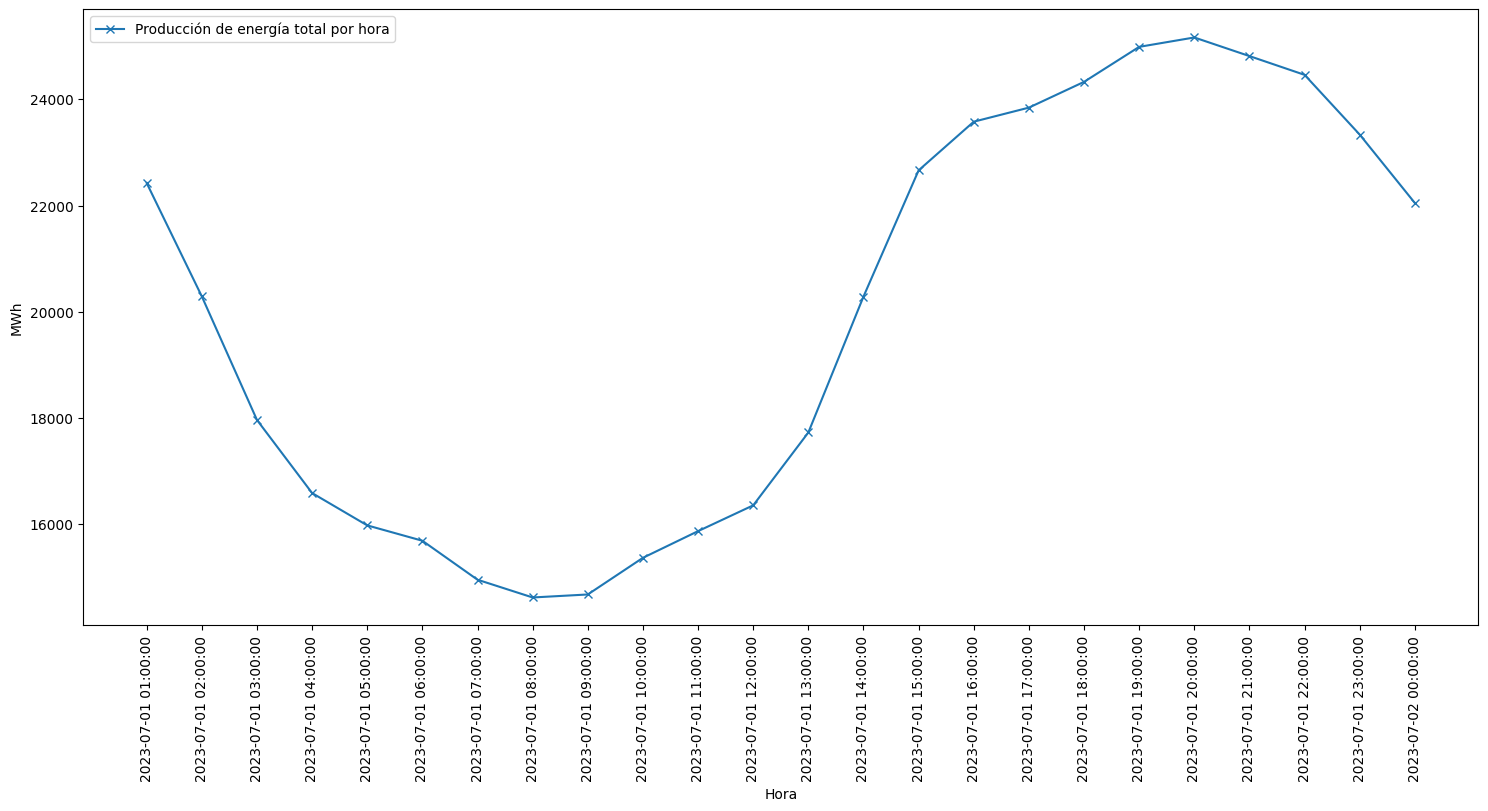

In [35]:
produccion_total = df_energia_demanda.groupby(df_energia_demanda['hora'])[['energía', 'demanda']].sum().reset_index()
produccion_total['demanda'] = produccion_total['demanda']/10

plt.figure(figsize=(18,8))

plt.plot(produccion_total['hora'], produccion_total['energía'], label = 'Producción de energía total por hora', marker='x')

plt.xlabel('Hora')
plt.ylabel('MWh')
plt.xticks(rotation=90)

plt.legend()
plt.show

##### ¿Cómo compara con respecto a la demanda?

<function matplotlib.pyplot.show(close=None, block=None)>

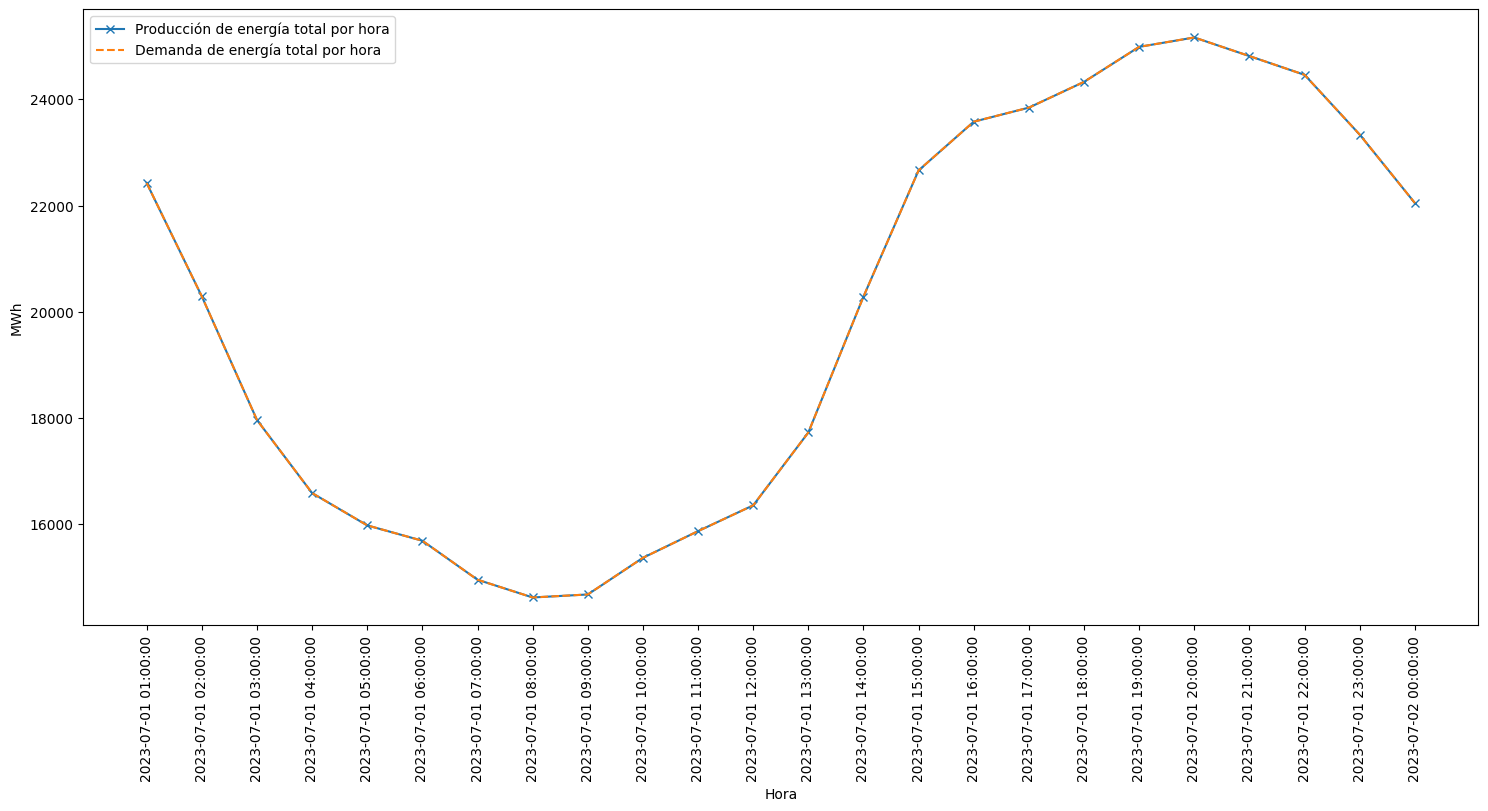

In [36]:
plt.figure(figsize=(18,8))

plt.plot(produccion_total['hora'], produccion_total['energía'], label = 'Producción de energía total por hora', marker='x')
plt.plot(produccion_total['hora'], produccion_total['demanda'], label = 'Demanda de energía total por hora', linestyle = '--')

plt.fill_between(produccion_total['hora'], produccion_total['energía'], produccion_total['demanda'], 
                 where = (produccion_total['energía'] >= produccion_total['demanda']), facecolor='green', alpha = 0.5)

plt.xlabel('Hora')
plt.ylabel('MWh')
plt.xticks(rotation=90)

plt.legend()
plt.show

Hay una coincidencia casi perfecta. Pero al mirar con lupa los datos en formato tabla, se evidencian diferencias. Visualmente estas diferencias son:

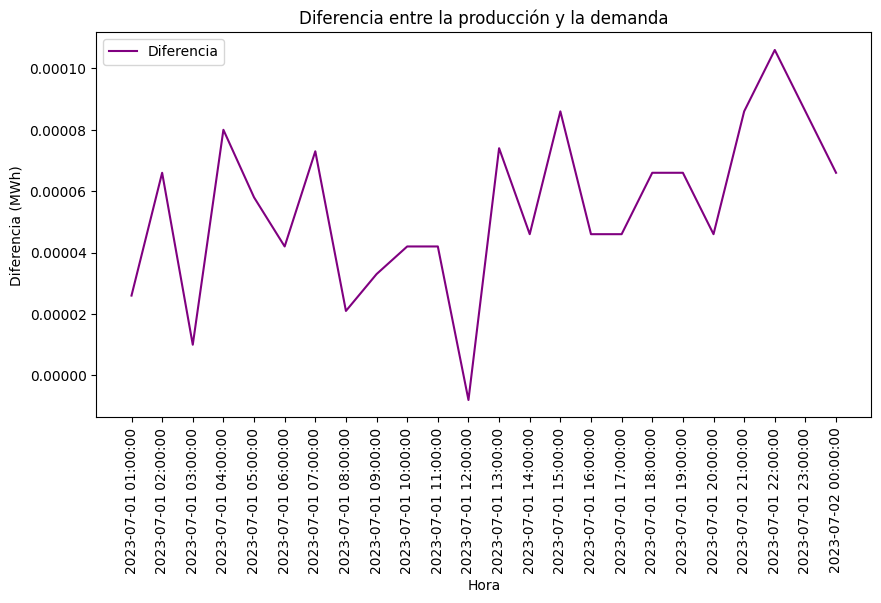

In [37]:
# Calcular la diferencia entre la producción y la demanda
produccion_total['diferencia'] = produccion_total['energía'] - produccion_total['demanda']

plt.figure(figsize=(10,5))

plt.plot(produccion_total['hora'], produccion_total['diferencia'], label='Diferencia', color='purple')

plt.title('Diferencia entre la producción y la demanda')
plt.xlabel('Hora')
plt.ylabel('Diferencia (MWh)')
plt.legend()
plt.xticks(rotation=90)


plt.show()

##### Cuál es el coste incurrido por cada central en cada hora, desglosado en sus componentes (combustible, operación y sanitario).

In [38]:
# Transformamos el dataframe P_c a un formato largo
P_c_long = P_c.reset_index().melt(id_vars='index', var_name='hora', value_name='costo_combustible')
P_c_long.rename(columns={'index':'central'}, inplace=True)
P_c_long = P_c_long.astype({'hora': 'string'})

In [39]:
costos = pd.merge(df_energia_demanda, P_c_long,  how='left', left_on=['central','hora'], right_on = ['central','hora'])
costos['costo_combustible'] = costos['energía'] * costos ['costo_combustible']

In [40]:
O_c_long = O_c.reset_index().melt(id_vars='index', var_name='hora', value_name='costo_operativo')
O_c_long.rename(columns={'index':'central'}, inplace=True)
O_c_long = O_c_long.astype({'hora': 'string'})

In [41]:
costos = pd.merge(costos, O_c_long,  how='left', left_on=['central','hora'], right_on = ['central','hora'])

In [42]:
S_ch_T = S_ch.T
S_ch_T_long = S_ch_T.reset_index().melt(id_vars='central', var_name='hora', value_name='costo_sanitario')
S_ch_T_long.rename(columns={'index':'central'}, inplace=True)
S_ch_T_long = S_ch_T_long.astype({'hora': 'string'})

In [43]:
costos = pd.merge(costos, S_ch_T_long,  how='left', left_on=['central','hora'], right_on = ['central','hora'])
costos['costo_sanitario'] = costos['energía'] * costos ['costo_sanitario']

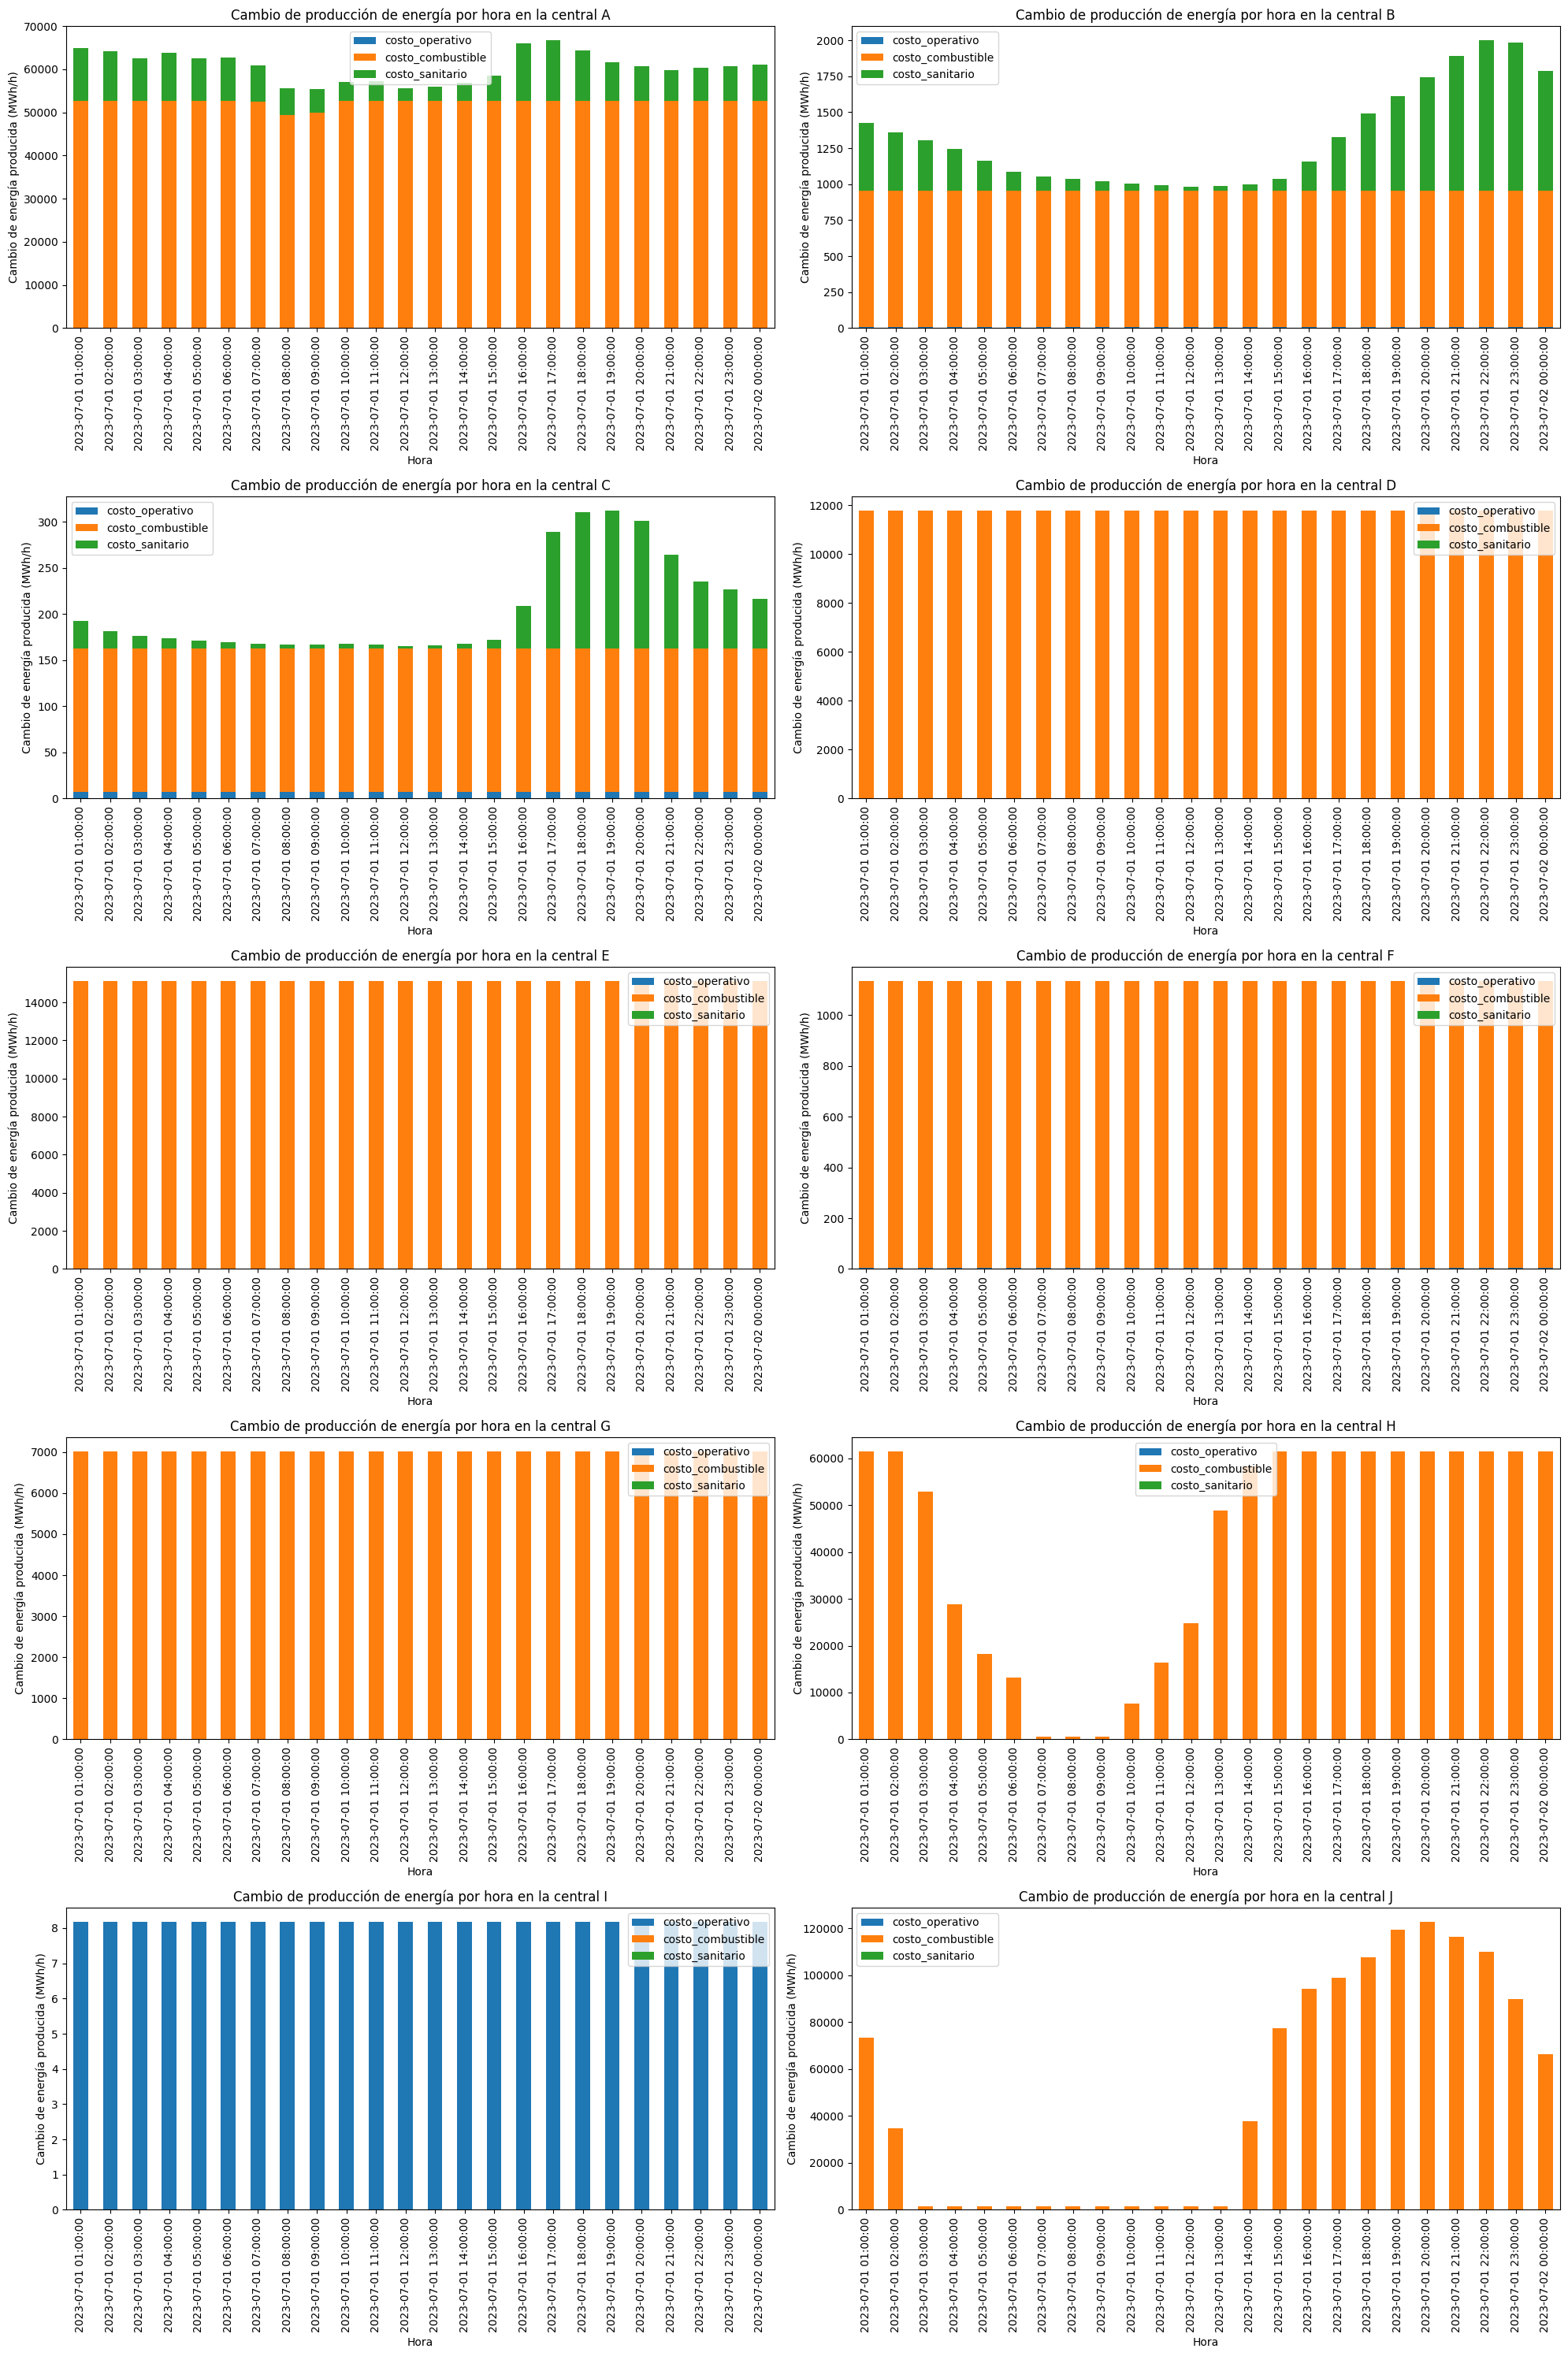

In [44]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,30))

for i, central in enumerate(centrals):
    row = i // 2
    col = i % 2
    df_central = costos[costos['central'] == central]

    df_central.groupby('hora').sum()[['costo_operativo', 'costo_combustible', 'costo_sanitario']].plot(kind='bar', stacked=True, ax=axs[row, col])
    
    axs[row, col].set_title(f'Cambio de producción de energía por hora en la central {central}')
    axs[row, col].set_xlabel('Hora')
    axs[row, col].set_ylabel('Cambio de energía producida (MWh/h)')
    axs[row, col].tick_params(axis='x', rotation=90)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

##### Cuál es el coste total por hora.


In [45]:
costos['costo total'] = costos['costo_operativo'] + costos['costo_combustible'] + costos['costo_sanitario']
costo_total = costos.groupby(costos['hora'])['costo total'].sum().reset_index()


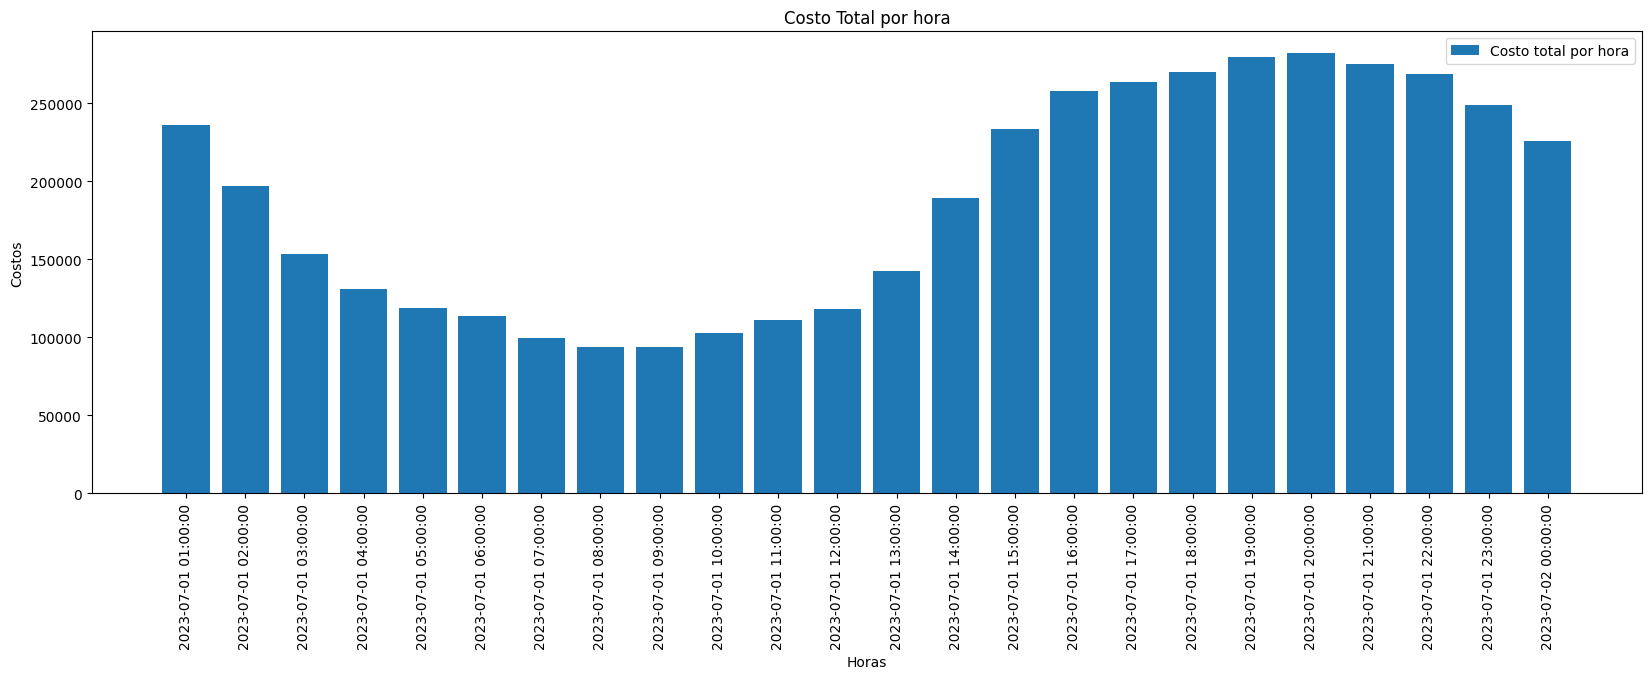

In [46]:
# Crea un gráfico de barras con un ancho adecuado
plt.figure(figsize=(20, 6))
plt.bar(costo_total['hora'], costo_total['costo total'], label ='Costo total por hora')

plt.xlabel('Horas')
plt.ylabel('Costos')
plt.title('Costo Total por hora')
plt.legend()
plt.xticks(rotation=90)
plt.show()


¿Qué horas son las más y las menos costosas?

In [47]:
costo_minimo = costo_total['costo total'].min()
costo_maximo = costo_total['costo total'].max()
hora_minima = costo_total['hora'].loc[costo_total['costo total']==costo_minimo].values[0]
hora_maxima = costo_total['hora'].loc[costo_total['costo total']==costo_maximo].values[0]

In [48]:
print(f'La hora menos costosa es: {hora_minima}')

La hora menos costosa es: 2023-07-01 09:00:00


In [49]:
print(f'La hora más costosa es: {hora_maxima}')

La hora más costosa es: 2023-07-01 20:00:00


Cuál es el coste por central en el día.


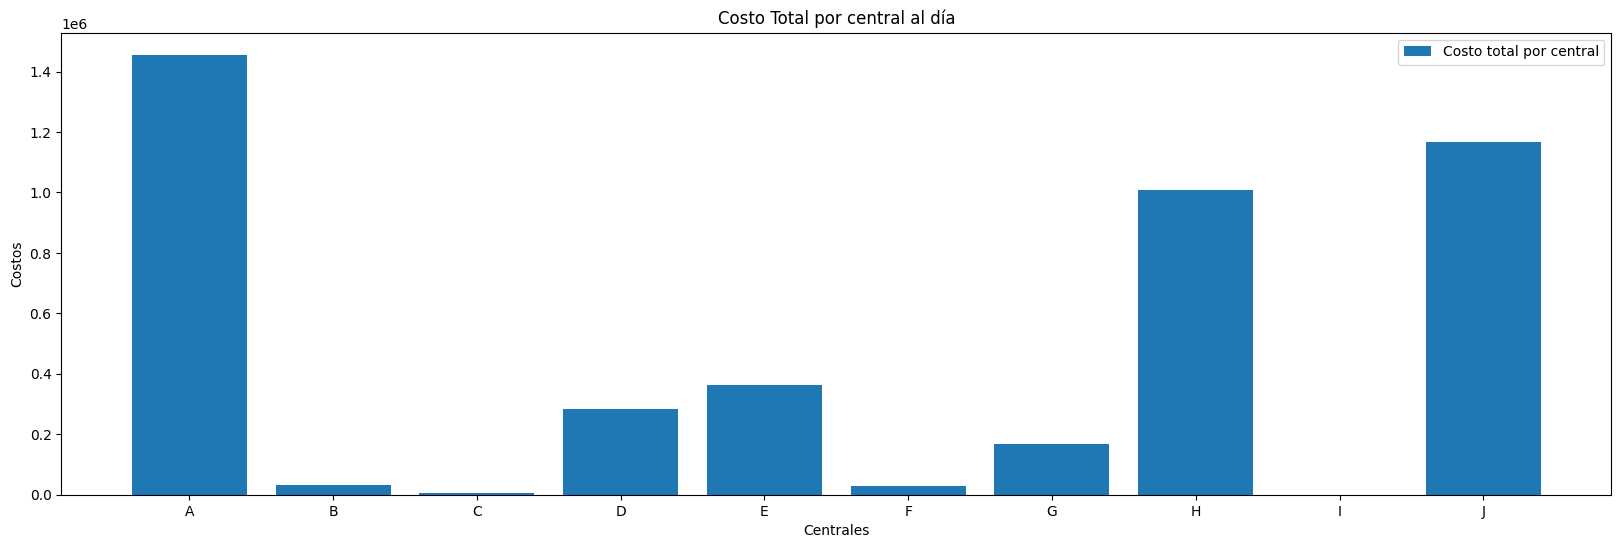

In [50]:
costo_total_por_planta = costos.groupby(costos['central'])['costo total'].sum().reset_index()
plt.figure(figsize=(20, 6))
plt.bar(costo_total_por_planta['central'], costo_total_por_planta['costo total'], label ='Costo total por central')

plt.xlabel('Centrales')
plt.ylabel('Costos')
plt.title('Costo Total por central al día')
plt.legend()
plt.show()


In [51]:
costo_minimo = costo_total_por_planta['costo total'].min()
costo_maximo = costo_total_por_planta['costo total'].max()
central_min = costo_total_por_planta['central'].loc[costo_total_por_planta['costo total']==costo_minimo].values[0]
central_max = costo_total_por_planta['central'].loc[costo_total_por_planta['costo total']==costo_maximo].values[0]

¿Qué centrales son las más y las menos costosas?


In [52]:
print(f'La central menos costosa es: {central_min}')

La central menos costosa es: I


In [53]:
print(f'La central más costosa es: {central_max}')

La central más costosa es: A


Cuál es el coste total del día


In [54]:
coste_dia = value(prob.objective)
print(f'El coste total del día: {coste_dia}')

El coste total del día: 4508697.3013742585


4. ¿Cuánto tiene que caer la demanda en % para que el problema esté en el límite de ser o no factible? Aquí puedes suponer que la demanda decae en el mismo porcentaje para las 24 horas del día. Muestra que para ese valor límite:


In [55]:
def hallar_limite_viable(demanda, C, H, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, E_c, beta, alpha):
    prob = LpProblem('Problema_de_la_demanda', LpMinimize)
    e_ch, x_ch, gamma_ch = crear_variables_decision(C, H)
    prob = crear_funcion_obj(prob, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, C, H)
    prob = anadir_restriccion_xch(prob, x_ch, C, H)
    prob = anadir_otras_restricciones(prob, H, C, e_ch, x_ch, E_c, beta, alpha, gamma_ch)
    for h in H:
        prob+= (lpSum([e_ch[c][h] for c in C])) == demanda.loc[h][0]

    return prob, e_ch, x_ch, gamma_ch

In [56]:
coeficiente = 1
paso = 0.01
status = 'Optimal'

while (status == 'Optimal'):
    demanda = daily_demand * coeficiente
    prob, e_ch, x_ch, gamma_ch = hallar_limite_viable(demanda, C, H, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, E_c, beta, alpha)
    status = LpStatus[prob.solve()]
    coeficiente-= paso    

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] <= x_ch[c][h] * E_c.loc[c][0]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] >= x_ch[c][h] * E_c.loc[c][0]*alpha[c]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [57]:
porcentaje_inviable = 100 - (coeficiente+paso)*100
print(f"El porcentaje de reducción de demanda de energía que hace que la solución sea inviable es: ", porcentaje_inviable, "%")


El porcentaje de reducción de demanda de energía que hace que la solución sea inviable es:  58.00000000000005 %


In [58]:
limite_viable = daily_demand * (coeficiente + 2*paso)
prob, e_ch, x_ch, gamma_ch = hallar_limite_viable(limite_viable, C, H, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, E_c, beta, alpha)

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] <= x_ch[c][h] * E_c.loc[c][0]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] >= x_ch[c][h] * E_c.loc[c][0]*alpha[c]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [59]:
status = prob.solve()
print('Status:', LpStatus[status])
value(prob.objective)

Status: Optimal


910405.7955026062

In [60]:
df_result_limits = almacenar_resultados_modelo(prob)
df_result_limits['hora'] = pd.to_datetime(df_result_limits['hora'])
df_energia_demanda_limite = pd.merge(df_result_limits, D_h, on='hora', how='left')
df_energia_demanda_limite = df_energia_demanda_limite.astype({'hora': 'string'})


En algún momento del día la producción cae a su mínimo posible. ¿Qué momento es ese y por qué?

<function matplotlib.pyplot.show(close=None, block=None)>

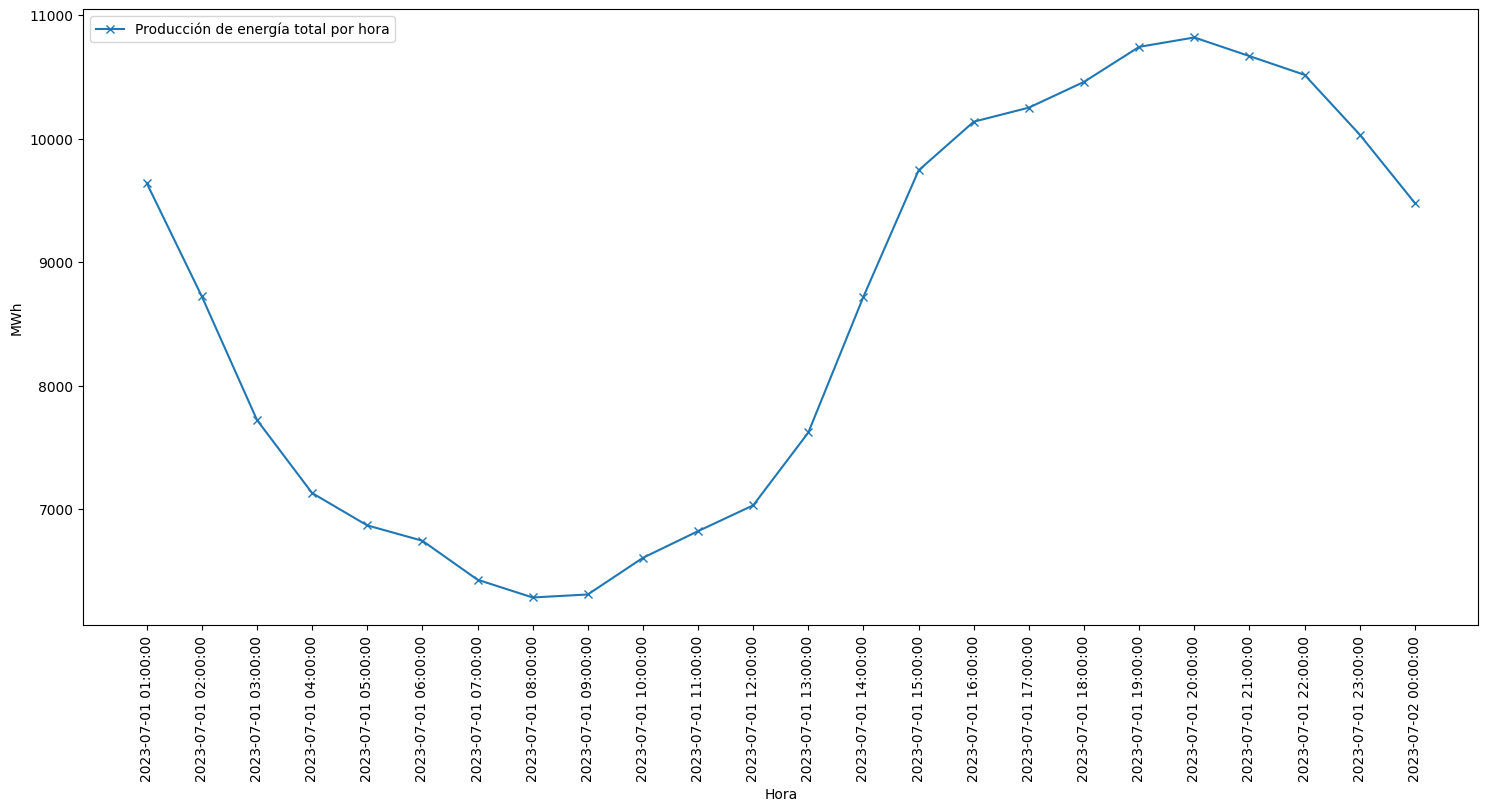

In [61]:
produccion_total_limite = df_energia_demanda_limite.groupby(df_energia_demanda_limite['hora'])[['energía', 'demanda']].sum().reset_index()
produccion_total_limite['demanda'] = produccion_total_limite['demanda']/10

plt.figure(figsize=(18,8))

plt.plot(produccion_total_limite['hora'], produccion_total_limite['energía'], label = 'Producción de energía total por hora', marker='x')

plt.xlabel('Hora')
plt.ylabel('MWh')
plt.xticks(rotation=90)

plt.legend()
plt.show

In [62]:
produccion_minima = produccion_total_limite['energía'].min()
hora_minima = produccion_total_limite['hora'].loc[produccion_total_limite['energía']==produccion_minima].values[0]
print(f'El momento en que la producción cae a su mínimo posible es: {hora_minima}')

El momento en que la producción cae a su mínimo posible es: 2023-07-01 08:00:00


In [63]:
demanda_minima = produccion_total_limite['demanda'].min()
hora_minima = produccion_total_limite['hora'].loc[produccion_total_limite['demanda']==demanda_minima].values[0]
print(f'El momento en que la demanda es menor es: {hora_minima}')

El momento en que la demanda es menor es: 2023-07-01 08:00:00


El momento del día en que la producción cae a su mínimo posible es a las 8 AM, debido a que este es el momento con menor demanda energética.

El coste es más bajo que en el escenario anterior. ¿Cuál sería este coste mínimo?


In [64]:
status = prob.solve()
print("Status: ", LpStatus[status])
costo_limite = value(prob.objective) 
value(prob.objective)


Status:  Optimal


910405.7955026062

In [65]:
dif =round((100 - ((costo_limite*100)/costo_inicial)),2)
print(dif)

79.81


In [66]:
print(f'El costo mínimo para este escenario es {costo_limite}, comparado con el costo inicial de {costo_inicial}, lo que indica una caída del {dif}% en el costo')

El costo mínimo para este escenario es 910405.7955026062, comparado con el costo inicial de 4508697.3013742585, lo que indica una caída del 79.81% en el costo


Si decae todavía un poco más, el problema se convierte en no factible.

In [67]:
limite_viable = daily_demand * (coeficiente + paso)
prob, e_ch, x_ch, gamma_ch = hallar_limite_viable(limite_viable, C, H, P_c, e_ch, x_ch, O_c, S_ch, ON_c, gamma_ch, E_c, beta, alpha)

C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] <= x_ch[c][h] * E_c.loc[c][0]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += e_ch[c][h] >= x_ch[c][h] * E_c.loc[c][0]*alpha[c]
C:\Users\nikky\AppData\Local\Temp\ipykernel_28424\602836359.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [68]:
status = prob.solve()
print('Status:', LpStatus[status])
value(prob.objective)

Status: Infeasible


875612.3748042658

### Apartado B (6 puntos)

**Volviendo a la demanda original, y sin suponer ya que las centrales no se puedan apagar** (excepto las nucleares, que por restricción tienen que operar siempre), **ni tampoco que al principio tengan por qué estar todas encendidas**, se pide:

1. Formular el problema matemáticamente de cómo se debe operar a lo largo del día.
  * ¿Qué cambios hace falta introducir con respecto a la formulación del apartado A?
2. Trasladar esta nueva formulación a la librería `PuLP`.
3. Resolver el problema y analizar la solución obtenida, comparando con el resultado obtenido antes:
   * ¿Cómo varía la producción de energía de cada central? La demanda sigue siendo la misma, pero es posible que no se opere exactamente igual que antes...
   * ¿Hay alguna central que se desactive o active? Si es así, ¿en qué horas?
   * ¿Hay alguna siempre encendida (además de las nucleares)?
   * ¿Y alguna siempre apagada?
   * ¿Cómo varía la distribución de costes? ¿Es más barato o más caro que antes el total del día? ¿Por qué?
4. ¿Cuánto tiene que subir la demanda en % para que el problema esté en el límite de ser o no factible? De nuevo supón que **la demanda aumenta en el mismo porcentaje para las 24 horas del día**. Muestra que para ese valor límite:
  * En algún momento del día la producción sube al máximo posible. ¿Qué momento es ese y por qué?
  * El coste es mayor que con la demanda predicha. ¿Cuál sería ese coste máximo?
  * Si sube todavía un poco más, el problema se convierte en no factible.



La **Función objetivo** puede ser expresada como: 

$$
\min \left( \sum_{c \in C} \sum_{h \in H} P_c \; e_{ch} + \sum_{c \in C} \sum_{h \in H} O_c \; x_{ch} + \sum_{c \in C} \sum_{h \in H} S_{ch} \; e_{ch} + \sum_{c \in C} \sum_{h \in H} ON_c \cdot  \gamma_{c,h} \right) 
$$
$
\text{s.t.}
$
$$

\sum_{c \in C} e _{c,h} \geq D_h  \; \forall\;    h \in H  \hspace{35pt} \text{(Satisfacción de la demanda)}

$$

$$
 e_{c,h} \leq  x_{c,h} \cdot E_c \; \forall \;  h \in H, c \in H   \hspace{15pt} \text{(Producción de energía máxima)}

$$


$$
e_{c,h} \leq x_{c,h} \cdot E_c \cdot \alpha \; \forall \; h \in  H,  \hspace{25pt} \text{(Producción de energía mínima)}  \\
\text{Donde: }\\

\alpha = 0.8 \; \forall \; c \in \text{Conjunto de centrales nucleares}\\
\alpha = 0.01 \; \forall \; c \notin \text{Conjunto de centrales nucleares}\\

$$

$$

\hspace{50pt} \| e_{c,h} - e_{c,h-1} \| \leq \beta \cdot E_c \; \forall \; h \in H, \hspace{15pt} \text{(Cambio máximo de producción de energía)}\\
\text{Donde: } \\
        \beta = 0.2 \; \forall \; c \in \text{Conjunto de centrales nucleares} \\
        \beta = 0.25 \; \forall \; c \in \text{Conjunto de centrales a carbón} \\
        \beta = 1 \; \forall \; c \notin \text{Conjunto de centrales nucleares o carbón}

$$


$$

x_{c,h} = 1 \; \forall \;   h \in H , c \in \text{Conjunto de centrales nucleares} \;\hspace{15pt} \text{(Estado de plantas nucleares)}\\
  
$$

$$

\gamma_{c,h} = \| x_{c,h-1} - x_{c,h} \| \hspace{15pt} \text{(Cambio de estado de encendido/apagado)}\\
$$

 * ¿Qué cambios hace falta introducir con respecto a la formulación del apartado A?

Debido a que en el apartado 1 se definió la función de manera general, no se deben realizar cambios al planteamiento de la formulación matemática.
En este caso particular, a la hora de realizar la implementación, no se definirá Xc,h como 1 para todas las centrales, debido a que pueden existir cambios de estados, ni se asume que todas inician encendidas. 

### Apartado C (opcional)

Tanto en el apartado A como el B hemos optimizado la gestión de únicamente un día, pero tenemos datos de un mes completo. Si nos imaginamos que tenemos que planificar para todo el mes de julio completo, hay 2 estrategias posibles:
1.   Hacerlo a las bravas, es decir, **formular el problema completo para todo el mes e intentar resolverlo**.
2.   **Hacerlo día a día**, es decir, optimizar primero para el día 1 sin más, a partir de cómo se queda la situación al final del día 1 optimizar para el día 2 sin mirar más allá, a partir de ese resultado optimizar para el día 3, etc.

La ventaja de la primera aproximación es que **obtendría la solución realmente óptima, pero tiene el inconveniente de que según va creciendo de tamaño el problema a resolver, el tiempo y recursos necesarios para resolverlo pueden terminar siendo excesivos**.

En cambio, **la ventaja de la segunda aproximación es que resolver el problema para cada día es rápido (como ya hemos visto), pero como cada día sólo optimizamos sin mirar más allá, tomaremos decisiones subóptimas en cuanto a coste** conjunto, dado que es como si estuviéramos a ciegas de cuál va a ser la demanda del siguiente día en adelante.

<u>Plantea y programa el problema para el mes completo</u> (ya sea en la modalidad 1 o la 2) <u>y comenta los resultados obtenidos</u>.

**En el caso de que te atrevas con ambas modalidades, compara los costes para ver hasta qué punto la modalidad 2 es subóptima con respecto a la 1**.



## Criterios de evaluación

Para las formulaciones matemáticas:
* Corrección de las fórmulas
* Cumplimiento con todas las especificaciones del problema
* Nomenclatura intuitiva de las variables
* Explicación de qué representa cada una

Para la traducción a código de las formulaciones:
* Corrección del código y ejecución sin errores
* Resultados acorde con lo esperado
* Dar respuesta a las preguntas formuladas (aquí se pueden añadir al notebook tantas celdas de texto como se consideren necesarias, además de las del código propiamente dicho)
* Buen estilo de código (estructuración, modularidad, documentación, etc.)

Para la parte opcional:
* Puntos extra acorde con lo realizado